<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.975 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2022-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'informàtica, multimèdia i telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 1: Artificial and convolutional neural networks with Keras

Throughout this practice we will implement several neural network models to classify images from a database of satellite images. Specifically:
- A fully connected network will be implemented to establish a reference model or <i>baseline</i>
- A convolutional network will be implemented
- An autoencoder will be implemented
- A deep convolutional network will be implemented from a known model (VGG16) pre-trained in Imagenet using <i>transfer-learning</i>

## 0. Context and library loading
Satellite images are key in monitoring land use and cover, issues relevant to environmental management, urban planning, sustainability and combating climate change.

In this practice, we will work with the [UC Merced Land Use Data](http://weegee.vision.ucmerced.edu/datasets/landuse.html) database, which consists of 256x256 pixel satellite images of 21 different scenes: the classes are diverse, containing scenes and images of airplanes or rivers, among other categories.

Specifically, we will work with an augmented version of this database that is available in a [Kaggle repository](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification). In this version, several data augmentation processes have been carried out so that the number of images per class increases from 100 to 500.

**Note: It is recommended to do the practice in the environment offered by the Kaggle platform, since it offers a free environment with 30 hours of weekly GPU use.**

Throughout the entire practice, to create the different networks, we will alternate between using the [Sequential](https://keras.io/guides/sequential_model/) model and the [Functional](https://keras.io/guides/functional_api/) model of Keras through the [Sequential](https://keras.io/api/models/sequential/) and [Model](https://keras.io/api/models/model/) classes respectively.

Let's start by loading the most relevant libraries:

In [ ]:
import tensorflow as tf
print("TF version   : ", tf.__version__)

print("GPU available: ", tf.config.list_physical_devices('GPU'))

import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.11.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.11.0


In [ ]:
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import Sequential, Model

In [ ]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint

## 1. Download, analysis and pre-processing of the data (1.5 points)

In this section we will explore the database and prepare the loading of the images for the models in the following sections.

To download the database we have 2 options depending on whether we decide to work locally or from the Kaggle environment:
- If we work locally we must download the database from the following [link](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification/download?datasetVersionNumber=3) (it is a .zip file that occupies 2 GB) and unzip it.
- If we work from Kaggle. We must upload the Notebook of the statement to the platform (for this you can follow the first 6 steps of the following [article](https://rajputankit22.medium.com/how-to-upload-my-own-notebook-to-kaggle-2b0dedbb5a6b)) and then, once the notebook is uploaded, click the '+ Add Data' button and in the search box enter the address 'https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification' . Once the dataset is found, click the '+' button (Add Dataset), and from that moment you will have the database accessible at the path <code>../input/</code>.

Once we have the database accessible, we will inspect it.

The images are grouped in 2 different ways:
- In the <code>/landuse-scene-classification/images/</code> folder there is the total of the images separated by classes (each class in a different folder). But a separation has not been made into training and test sets (or training, validation and test).
- In the <code>/landuse-scene-classification/images_train_test_val/</code> folder there are 3 folders (<code>test</code>, <code>train</code> and <code>validation</code>) where the total of the images has been separated randomly. In each of the 3 folders, we have images of the 21 classes grouped in their corresponding folders. In the root folder <code>/landuse-scene-classification/</code> we have 3 .csv files with the distribution of each folder.

In this exercise we will use the already partitioned dataset, that is, we will work with the images found in the path <code>/landuse-scene-classification/images_train_test_val/</code>.

### 1.1. Analysis of the .csv files

From the .csv files we can see how the data has been distributed. For example:

In [5]:
train = pd.read_csv('../input/landuse-scene-classification/train.csv')
train.head(5)

Unnamed: 0                              Filename  Label     ClassName
0        5818              runway/runway_000259.png     16        runway
1        1327  intersection/intersection_000348.png     10  intersection
2        2529  agricultural/agricultural_000025.png      0  agricultural
3        3865        chaparral/chaparral_000195.png      5     chaparral
4        2024          airplane/airplane_000260.png      1      airplane

#### Extract class names

In [ ]:
def class_extractor(df, col_name) -> list:
	"""
	Extracts the name of the classes from the passed dataframe.

	Parameters:
	-----------
	df: pd.DataFrame
		Dataframe containing the classes.
	col_name: str
		Name of the column containing the classes.

	Returns:
	--------
	list[str]
		List with the names of the classes.
	"""
	return df[col_name].unique().tolist()

classes = class_extractor(df=train, col_name='ClassName')
print("The unique classes are:")
pprint.pprint(classes)
print(f"The length of the classes list is: {len(classes)}")

The unique classes are:
['runway',
 'intersection',
 'agricultural',
 'chaparral',
 'airplane',
 'storagetanks',
 'tenniscourt',
 'overpass',
 'harbor',
 'buildings',
 'mediumresidential',
 'baseballdiamond',
 'golfcourse',
 'freeway',
 'sparseresidential',
 'river',
 'mobilehomepark',
 'forest',
 'beach',
 'parkinglot',
 'denseresidential']
The length of the classes list is: 21


#### Number of instances per set

A set is understood as each of the datasets, therefore, the different files will be loaded and the number of instances of each will be calculated. The **train** set has already been loaded previously and does not need to be loaded again.

In [ ]:
test = pd.read_csv('../input/landuse-scene-classification/test.csv')
validation = pd.read_csv('../input/landuse-scene-classification/validation.csv')

In [7]:
print(f"The total number of instances from the train set is {len(train)}")
print(f"The total number of instances from the test set is {len(test)}")
print(f"The total number of instances from the validation set is {len(validation)}")

The total number of instances from the train set is 7350
The total number of instances from the test set is 1050
The total number of instances from the validation set is 2100


#### Number of instances per class
The number of instances of each class will be calculated for each dataset.

In [ ]:
print("The number of instances of each class for the train set is:")
print(f"{train['ClassName'].value_counts()}")

print("\nThe number of instances of each class for the test set is:")
print(f"{test['ClassName'].value_counts()}")

print("\nThe number of instances of each class for the validation set is:")
print(f"{validation['ClassName'].value_counts()}")

El nombre d'instàncies de cada classe per al train set és:
runway               350
baseballdiamond      350
parkinglot           350
beach                350
forest               350
mobilehomepark       350
river                350
sparseresidential    350
freeway              350
golfcourse           350
mediumresidential    350
intersection         350
buildings            350
harbor               350
overpass             350
tenniscourt          350
storagetanks         350
airplane             350
chaparral            350
agricultural         350
denseresidential     350
Name: ClassName, dtype: int64

El nombre d'instàncies de cada classe per al test set és:
river                50
airplane             50
baseballdiamond      50
agricultural         50
parkinglot           50
freeway              50
sparseresidential    50
mobilehomepark       50
forest               50
intersection         50
runway               50
mediumresidential    50
beach                50
denseresidentia

<strong>Comments:</strong>
<br><br>
The names of the classes that make up the different sets are: <i>runway, intersection, agricultural, chaparral, airplane, storagetanks, tenniscourt, overpass, harbor, buildings, mediumresidential, baseballdiamond, golfcourse, freeway, sparseresidential, river, mobilehomepark, forest, beach, parkinglot</i> and <i>denseresidential</i>.

As stated, the number of unique classes is 21.

On the other hand, it can be seen that the total number of instances is <i>10500</i>, separated into the sets of <i>train (7350 instances), validation (2100 instances)</i> and <i>test (1050 instances)</i>.

Finally, you can see how the classes in each dataset are balanced since they have the same number of instances. Specifically, the <i>train</i> set has 350 instances for each class, the <i>validation</i> set has 100, and <i>test</i> has 50 instances per class. In total, there are 500 instances per class. Therefore, if you want to use the data for a classification model, you will not need to implement techniques to correct the balance of the classes in order to avoid biases during training and erroneous predictions.

<strong> References: </strong>
- Tarek Amr, Hands-On Machine Learning with scikit-learn and Scientific Python Toolkits (p. 12).
- Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow (p. 674).

### 1.2. Analysis of image folders.

Although it is assumed that each .csv file perfectly reflects the content of each data set, we must ensure that the content of the folders corresponds to what is written in each file. For this reason, it is requested:

In [4]:
# Setting the main path for images
MAIN_PATH = os.path.join('../input/', 'landuse-scene-classification', 'images_train_test_val')

#### Number of images for each category (folder)

In [6]:
def calculate_number_images(folder: str):
	"""
	Counts the images for each subfolder in the provided folder path.

	Parameters:
	-----------
	folder_path: str
		Path to the folder containing the subfolders with the images.
	"""
	# Iterate over the subfolders to calculate the number of files in each of them
	for subfolder in os.listdir(os.path.join(MAIN_PATH, folder)):
		print(f"Images in {subfolder}: {len(os.listdir(os.path.join(MAIN_PATH, folder, subfolder)))}")

In [ ]:
calculate_number_images('train')

Images in airplane: 350
Images in tenniscourt: 350
Images in river: 350
Images in denseresidential: 350
Images in parkinglot: 350
Images in storagetanks: 350
Images in overpass: 350
Images in sparseresidential: 350
Images in mediumresidential: 350
Images in intersection: 350
Images in baseballdiamond: 350
Images in runway: 350
Images in chaparral: 350
Images in freeway: 350
Images in beach: 350
Images in buildings: 350
Images in harbor: 350
Images in mobilehomepark: 350
Images in forest: 350
Images in golfcourse: 350
Images in agricultural: 350


In [ ]:
calculate_number_images('validation')

Images in airplane: 100
Images in tenniscourt: 100
Images in river: 100
Images in denseresidential: 100
Images in parkinglot: 100
Images in storagetanks: 100
Images in overpass: 100
Images in sparseresidential: 100
Images in mediumresidential: 100
Images in intersection: 100
Images in baseballdiamond: 100
Images in runway: 100
Images in chaparral: 100
Images in freeway: 100
Images in beach: 100
Images in buildings: 100
Images in harbor: 100
Images in mobilehomepark: 100
Images in forest: 100
Images in golfcourse: 100
Images in agricultural: 100


In [ ]:
calculate_number_images('test')

Images in airplane: 50
Images in tenniscourt: 50
Images in river: 50
Images in denseresidential: 50
Images in parkinglot: 50
Images in storagetanks: 50
Images in overpass: 50
Images in sparseresidential: 50
Images in mediumresidential: 50
Images in intersection: 50
Images in baseballdiamond: 50
Images in runway: 50
Images in chaparral: 50
Images in freeway: 50
Images in beach: 50
Images in buildings: 50
Images in harbor: 50
Images in mobilehomepark: 50
Images in forest: 50
Images in golfcourse: 50
Images in agricultural: 50


The number of images in the *.csv* files matches the number of images in each of the subfolders. Thus, for each class in the *train* folder it is 350 images, for the classes in the *validation* folder it is 100, and finally for the classes in the *test* folder it is 50 images.

#### Image display by category and dynamic range

In [13]:
def visualize_images(folder: str, num_cols: int) -> None:
	"""
	Shows a single image for each subfolder in the provided folder path.
	For simplicity, the first image is selected. Also, prints the dynamic range
	for that image (mínimum and màxim values).

	Parameters:
	-----------
	folder_path: str
		Path to the folder containing the subfolders with the images.
	num_cols: int
		Number of columns in the grid of images.

	Returns:
	--------
	None
	"""
	# Calculate the number of rows needed to plot the images based on num_cols
	# and the subfolders in folder
	num_rows = (len(os.listdir(os.path.join(MAIN_PATH, folder))) + num_cols - 1) // num_cols
	fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 11))
	# Iterate for each subfolder and plot the first image in each element of the
	# grid defined by axs
	for idx, subfolder in enumerate(os.listdir(os.path.join(MAIN_PATH, folder))):
		# Calculate the row and column index for the current subfolder
		row_idx = idx // num_cols
		col_idx = idx % num_cols
		# Get the first image in the subfolder and plot it
		img = cv2.imread(os.path.join(MAIN_PATH, folder, subfolder,
					os.listdir(os.path.join(MAIN_PATH, folder, subfolder))[0]),
					cv2.IMREAD_COLOR)
		# Split the image into color channels
		b, g, r = cv2.split(img)
		# Find the minimum and maximum pixel values in each color channel
        # Source: https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707
		min_b, max_b, _, _ = cv2.minMaxLoc(b)
		min_g, max_g, _, _ = cv2.minMaxLoc(g)
		min_r, max_r, _, _ = cv2.minMaxLoc(r)
		axs[row_idx, col_idx].imshow(img)
		# Set the title with the name of the category and the dynamic range
		axs[row_idx, col_idx].set_title(f"Category {subfolder}\nDynamic range R: {min_r} - {max_r}\nDynamic range G: {min_g} - {max_g}\nDynamic range B: {min_b} - {max_b}")
	# Remove the empty plots
	for idx in range(len(os.listdir(os.path.join(MAIN_PATH, folder))), num_rows * num_cols):
		row_idx = idx // num_cols
		col_idx = idx % num_cols
		fig.delaxes(axs[row_idx, col_idx])
	plt.tight_layout()
	plt.show()

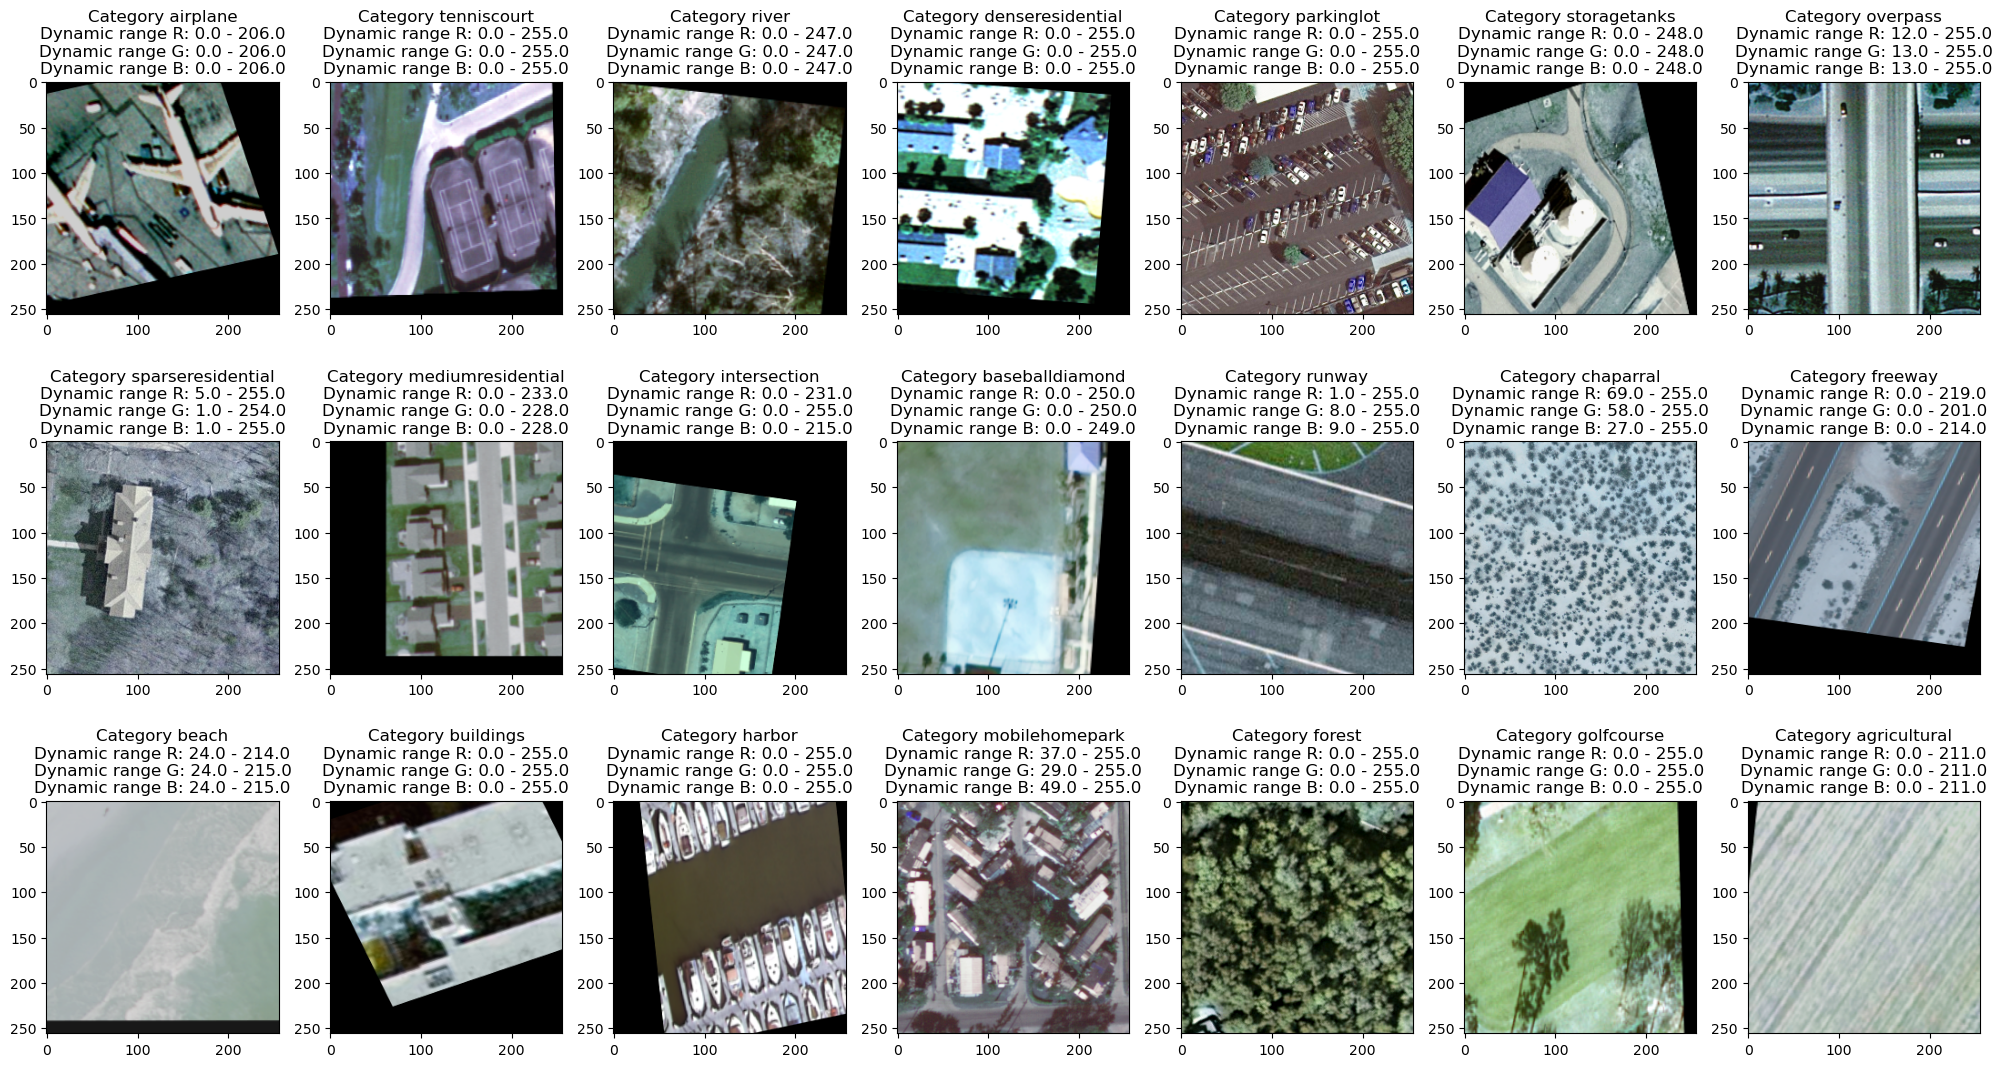

In [14]:
visualize_images('train', 7)

You can see that the images are in color, therefore, they will have three color channels R (red), G (green) and B (blue). The dynamic range of each of these channels goes from 0 to 255. In the title of each image, the specific dynamic range for each specific image has been represented.

### 1.3. Creating datasets in Keras/Tensorflow format

In order to create a database in Keras/Tensorflow format from the images provided, we will use the <code>**tf.keras.utils.image_dataset_from_directory()**</code> function, as it allows us to create databases from images saved in folders.

The documentation for this function can be found on both the [Keras](https://keras.io/api/data_loading/image/) and [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) websites.

In addition, we will take the opportunity to resize the images and make them 224x224, which is the size with which the VGG16 network was trained, which we will use in a later section.

In [5]:
def create_train_test_val_sets(
    folder_path: str, batch_size: int, image_size: tuple
):
	"""
	Creates the train, test and validation datasets from the provided folder path.
    
    Parameters:
    -----------
    folder_path: str
        String with the folder path.
    batch_size: int
        Value of images that will contain each batch.
    image_size: tuple
        Dimensions of the image.
	"""
	# Set the train, validation and test folders
	train_folder = os.path.join(folder_path, 'train')
	validation_folder = os.path.join(folder_path, 'validation')
	test_folder = os.path.join(folder_path, 'test')

	# Create the train, validation and test datasets with image_dataset_from_directory()
    # Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
	train_data = image_dataset_from_directory(
		train_folder, batch_size=batch_size, image_size=image_size,
		color_mode='rgb', shuffle=True, seed=42, validation_split=None,
		subset=None, interpolation='bilinear', follow_links=False,
		label_mode='categorical', crop_to_aspect_ratio=False
	)

	validation_data = image_dataset_from_directory(
		validation_folder, batch_size=batch_size, image_size=image_size,
		color_mode='rgb', shuffle=True, seed=42, validation_split=None,
		subset=None, interpolation='bilinear', follow_links=False,
		label_mode='categorical', crop_to_aspect_ratio=False
	)

	test_data = image_dataset_from_directory(
		test_folder, batch_size=batch_size, image_size=image_size,
		color_mode='rgb', shuffle=True, seed=42, validation_split=None,
		subset=None, interpolation='bilinear', follow_links=False,
		label_mode='categorical', crop_to_aspect_ratio=False
	)

	return train_data, validation_data, test_data

In [6]:
train_data, validation_data, test_data = create_train_test_val_sets(MAIN_PATH,
									batch_size=32,
									image_size=(224, 224))

Found 7350 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.


In [7]:
for image_batch, labels_batch in train_data:
	print(image_batch.shape)
	print(labels_batch.shape)
	break

(32, 224, 224, 3)
(32, 21)


You can see how the three requested datasets have been created and they contain the same number of rows as the total number of instances obtained by the *.csv* files. You can also see how the 21 classes have been correctly identified. Finally, if we look at the characteristics of one of the datasets, you can see how the images have been rescaled to the dimensions (224, 224) for each of the RGB channels and that the dimension of each batch is 32.

## 2. ANN Model (1.5 points)

In this section, we will train and evaluate a very simple fully connected model to establish a reference result.

Since in an artificial neural network the inputs are one-dimensional, the first thing we have to do is resize the input data (the images) to convert them into one-dimensional arrays.

Since working with 224x224 images in a fully connected network would imply training an excessively high number of parameters, we will define a model in which a resizing of the input images to a size of 32x32 and a flattening (*flattening*) of the pixels will be previously performed to generate a one-dimensional vector of size 3072 (32x32x3).

Later, we will train a classifier (a fully connected network) to carry out the classification of our data.

In this section we will use the layers [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) and [Dropout ](https://keras.io/api/layers/regularization_layers/dropout/) from keras.

#### Definition of the neural network model
The neural network will be defined based on the requirements of the statement.

In [90]:
# Definició de la xarxa
def ann_model(input_shape: tuple) -> tf.keras.Sequential:
	"""
	Creates a ANN model with the previous requirements.
    The input shape is first defined to be able to generate a
    model summary, but it is not strictly necessary since
    previous tests generated the same results during training.

    The code is based on the implementations found in:
    - https://www.tensorflow.org/tutorials/keras/classification
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).

	Parameters:
	-----------
	input_shape: tuple[int, int, int]
		The shape of the input tensor (height, width, channels).

	Returns:
	--------
	tf.keras.Sequential
		ANN model.
	"""
	model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
		Resizing(32, 32),
		Rescaling(1./255),
		Flatten(),
		Dense(units=1024, activation='relu'),
		Dropout(rate=0.5),
		# A softmax activation is used to output the probability to belong to
		# one of the 21 class (Source: pàg 24 de Fundamentos de las redes
		# neuronales convolucionales de J. Casas Roma i A. Bosch Rue)
		Dense(units=21, activation=tf.nn.softmax)
	])
	return model

In [11]:
model_ann = ann_model((224,224,3))

#### Network compilation
A function will be created to compile the network that will be reused in the rest of the sections.

In [ ]:
def compile_model(
    model: tf.keras.Sequential, learning_rate: float,
    optimizer: tf.keras.optimizers.Optimizer,
	loss: tf.keras.losses.Loss,
	metrics: list
) -> tf.keras.Sequential:
	"""
	Compiles the model with the provided parameters.

    The code is based on the implementations found in:
    - https://www.tensorflow.org/tutorials/keras/classification
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).

	Parameters:
	-----------
	model: tf.keras.Sequential
		ANN model.
	learning_rate: float
		Learning rate.
	optimizer: tf.keras.optimizers.Optimizer
		Optimizer.
	loss: tf.keras.losses.Loss
		Loss function.
	metrics: list[tf.keras.metrics.Metric]
		Metrics.

	Returns:
	--------
	tf.keras.Sequential
		Compiled ANN model.
	"""
	model.compile(
		optimizer=optimizer(learning_rate=learning_rate),
		loss=loss(),
		metrics=metrics
	)
	return model

When selecting the metric, you need to see what the dataset labels look like:

In [9]:
image_batch, labels_batch = next(iter(train_data))
image, label = image_batch[0], labels_batch[0]

In [10]:
label

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0.], dtype=float32)>

In this case, since we have a vector of dimension (21,) that is formed by zeros, except for the value of the corresponding label that is worth 1, we can see how the data is *one-hot encoded*. Therefore, the *loss* will be evaluated with the *CategoricalCrossentropy* that is designed for labels of this type. The evaluation metric that will be used will be the *accuracy* as requested by the statement.

**References:**

- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

In [33]:
compiled_ann_model = compile_model(model=model_ann, learning_rate=0.0001,
							optimizer=tf.keras.optimizers.Adam,
							loss=tf.keras.losses.CategoricalCrossentropy,
							metrics=['accuracy'])

In [35]:
compiled_ann_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              3146752   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 21)                21525     
                                                                 
Total params: 3,168,277
Trainable params: 3,168,277
No

#### Network Training
A function will be created to train neural networks based on different parameters. This can be reused in later sections.

In [ ]:
def train_nn_model(
	train_data: tf.data.Dataset,
	validation_data: tf.data.Dataset,
	compile_model: tf.keras.Sequential, 
	epochs: int = 100,
	batch_size: int = 32,
	patience: int = 10,
    checkpoint_filepath: str = 'placeholder.h5'
) -> tf.keras.callbacks.History:
	"""
	Trains the model with the provided parameters.

    The code is based on the implementations found in:
    - https://www.tensorflow.org/tutorials/keras/classification
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).

	Parameters:
	-----------
	compile_model: tf.keras.Sequential
		Compiled ANN model.

	Returns:
	--------
	tf.keras.callbacks.History
		Training history.
	"""
	# Define early stopping
	early_stop = tf.keras.callbacks.EarlyStopping(
													monitor='val_loss',
													patience=patience,
													restore_best_weights=True
												)
	# Define the checkpoint
	checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
		filepath=checkpoint_filepath,
		save_weights_only=True,
		monitor='val_loss',
		mode='min',
		save_best_only=True
	)

	# Train the model
	history = compile_model.fit(
		train_data, epochs=epochs, batch_size=batch_size,
		validation_data=validation_data, callbacks=[checkpoint_callback, early_stop]
	)
	return history

In [40]:
# Register the training time
start_time = time.time()

# Train the model
history_ann = train_nn_model(train_data, validation_data, compiled_ann_model, 
	epochs = 100, batch_size = 32, patience = 10, checkpoint_filepath = 'best_weights_ann_rgb.h5')

# Finish time register
end_time = time.time() - start_time
print(f"The total training time is {end_time} seconds")

Epoch 1/100
230/230 [==============================] - 26s 106ms/step - loss: 3.1073 - accuracy: 0.0676 - val_loss: 3.0118 - val_accuracy: 0.0714
Epoch 2/100
230/230 [==============================] - 24s 102ms/step - loss: 3.0047 - accuracy: 0.0812 - val_loss: 2.9674 - val_accuracy: 0.1133
Epoch 3/100
230/230 [==============================] - 25s 105ms/step - loss: 2.9574 - accuracy: 0.0967 - val_loss: 2.9411 - val_accuracy: 0.1324
Epoch 4/100
230/230 [==============================] - 24s 104ms/step - loss: 2.9186 - accuracy: 0.1117 - val_loss: 2.9112 - val_accuracy: 0.1357
Epoch 5/100
230/230 [==============================] - 29s 122ms/step - loss: 2.8792 - accuracy: 0.1332 - val_loss: 2.8777 - val_accuracy: 0.1324
Epoch 6/100
230/230 [==============================] - 24s 104ms/step - loss: 2.8371 - accuracy: 0.1423 - val_loss: 2.8527 - val_accuracy: 0.1576
Epoch 7/100
230/230 [==============================] - 29s 123ms/step - loss: 2.8044 - accuracy: 0.1536 - val_loss: 2.8201 -

In [25]:
# Load the weights from the .h5 file
model_ann.load_weights('/kaggle/working/best_weights_ann.h5')

#### Representation of *accuracy* and *loss*

In [9]:
def plot_history_categorical(
    history: tf.keras.callbacks.History, n_rows: int = 1, n_cols: int = 2,
    max_fontsize: int = 18, figure_size: tuple = (12, 3),
    metrics: list = ['accuracy', 'loss']
) -> None:
    """
    Plots the training and validation accuracy and loss for a history object.

    Parameters:
    -----------
    history: tf.keras.callbacks.History
        Training history.
    n_rows: int
        Number of rows of the figure.
    n_cols: int
        Number of columns of the figure.
    max_fontsize: int
        Maximum fontsize of the figure.
    figure_size: tuple [int, int]
        Size of the figure.
    metrics: list[str]
        Name of the metrics to plot.

    Returns:
    --------
    None
    """
    _, axes = plt.subplots(n_rows, n_cols, figsize=figure_size)

    if n_rows == 1 and n_cols == 1:
        axes.plot(history.history[f'{metrics[0]}'], color='steelblue', lw=2)
        axes.plot(history.history[f'val_{metrics[0]}'], color='crimson', lw=2)
        axes.set_title(f'{metrics[0].capitalize()}', fontsize=max_fontsize)
        axes.set_xlabel('Epoch', fontsize=max_fontsize-2)
        axes.set_ylabel(f'{metrics[0].capitalize()}', fontsize=max_fontsize-2)
        axes.tick_params(axis='both', which='major', labelsize=max_fontsize-4)
        axes.legend(['Train', 'Validation'], loc='best', fontsize=max_fontsize-4)
    else:
        for _, (ax, metric) in enumerate(zip(axes, metrics)):
            ax.plot(history.history[f'{metric}'], color='steelblue', lw=2)
            ax.plot(history.history[f'val_{metric}'], color='crimson', lw=2)
            ax.set_title(f'{metric.capitalize()}', fontsize=max_fontsize)
            ax.set_xlabel('Epoch', fontsize=max_fontsize-2)
            ax.set_ylabel(f'{metric.capitalize()}', fontsize=max_fontsize-2)
            ax.tick_params(axis='both', which='major', labelsize=max_fontsize-4)
            ax.legend(['Train', 'Validation'], loc='best', fontsize=max_fontsize-4)
    plt.tight_layout()
    plt.show()

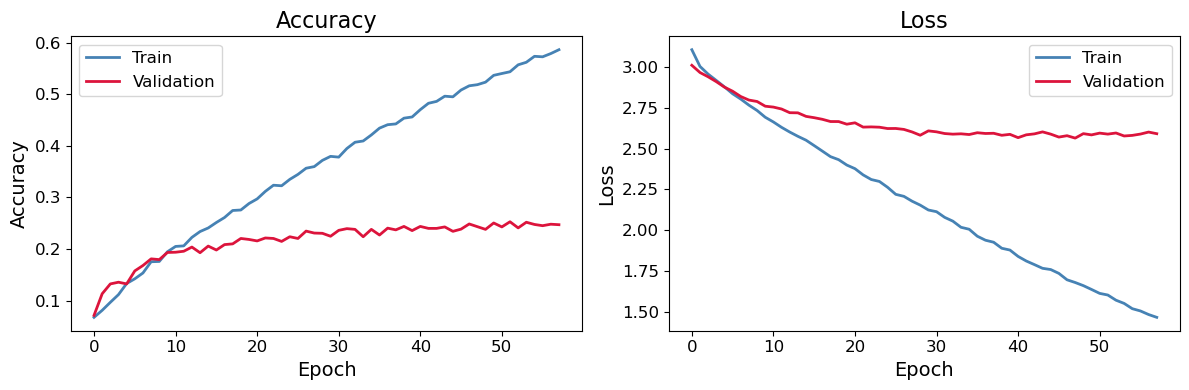

In [ ]:
plot_history_categorical(history=history_ann, n_rows=1, n_cols=2,
						max_fontsize=16, figure_size=(12, 4), metrics=['accuracy', 'loss'])

#### Model evaluation with the test set

In [47]:
# Evaluate the model with the test set
test_loss, test_acc = compiled_ann_model.evaluate(test_data, verbose=2)

33/33 - 5s - loss: 2.6287 - accuracy: 0.2514 - 5s/epoch - 159ms/step


<strong>Comments:</strong>
<br><br>
According to the output of <code>model_ann.summary()</code> the number of parameters to train is 3,168,277. The number of parameters to train is so large because we have <code>32x32x32</code> images which are equivalent to 3072 parameters and we pass them through a fully connected layer of 1024 neurons, then we have to apply the formula <code>(n_inputs + 1) * n_outputs</code> where <code>n_inputs + 1</code> refers to the dimensions that are passed to the fully connected layer added to the <i>bias (=1)</i> and <code>n_outputs</code> are the output dimensions of the layer. Therefore, <code>(32*32*3 + 1) * 1024 = 3,146,752</code>. Then, we have to add the parameters of the final layer to return the 21 neurons (<code>(1024 + 1) * 21 = 21,525</code>), resulting in 3,168,277 parameters. [2]

The total time it took to train the model was about 1552 seconds (~25 minutes). You can see how the training and validation <i>accuracy</i> are gradually increasing, while the <i>loss</i> decreases. Training has stopped at <i>epoch</i> 58 due to the implementation of <i>early stopping</i> which allows stopping training when there is no improvement in the validation accuracy, but rather when it starts to get worse, as explained on page 46 of [1]. Thus, the final values ​​of the <i>accuracies</i> are 0.5863 and 0.2471 for the training and validation sets, respectively, while the <i>losses</i> are 1.4655 and 2.5921, respectively.

Despite using <i>early stopping</i>, it seems that this large difference in <i>accuracies</i> indicates that there is <i>overfitting</i> and, therefore, the model is not able to generalize well (p. 35 of [1]). One way to avoid or minimize overtraining would be to use regularization techniques such as L2 or L1 regularization, modify the probability value in the <i>dropout</i> layer, artificially increase the data set, etc. (pp. 45 to 48 of [1]).

On the other hand, the evaluation of the model with the test set returns an <i>accuracy</i> of 0.2514 and a <i>loss</i> of 2.6287 which are very similar to the validation ones.

Finally, it should be noted that the results obtained with the ANN model are not very good since the accuracy on the validation and test sets is much lower than that of the training set. This indicates that this model is not suitable for image classification. In order to improve the results, it would be advisable to try other types of architectures and the convolutional networks of exercise 3, which could offer an improvement over the results observed here, since they are ideal for image processing. [1]

<strong>References:</strong>
<br><br>
[1] Jordi Casas Roma, <i>Las redes neuronales artificiales</i>, UOC (2023).

[2] Jordi Torres, <i>Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2</i>, Marcombo (2020).
<br><br>

## 3. Small convolutional network (2 points)

Given the low performance of the previous model, we will try another type of network with the aim of obtaining better results in the classification task that we have to carry out.

Convolutional networks (CNN) are especially suitable for modeling data where there are patterns in 2 dimensions, as is the case with images.

In the classification task, the structure of a CNN is divided into two large blocks:

* **Feature extractor block**: In this block, different levels of abstraction of the input image are generated using convolutional layers. The deeper these layers are, the more prepared they are for the classification task.
* **Classifier**: This block is made up of fully connected layers, the output of this block will be the probability associated with each class.

In the previous section, the "feature extractor" block was extremely simple, not to say non-existent. In this section, we will make use of convolutional layers to be able to learn better abstractions from the input images in order to improve their classification.

In this section we will use the layers [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/), [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/), [GlobalAveragePooling2D](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/), [Dense](https://keras.io/api/layers/core_layers/dense/) and [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) from keras.

**Note: It is recommended, from this point on, to do the training on a machine with GPU (can be activated on platforms such as Google Colab or Kaggle) in order to reduce training times.**

#### Definition of the convolutional neural network model

In [44]:
def small_cnn_model(input_shape: tuple) -> tf.keras.Model:
    """
    Creates a CNN model with the previous requirements.
    
    The code is based on the implementations found in:
    - https://www.tensorflow.org/tutorials/quickstart/advanced
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).

    Parameters:
    -----------
    input_shape: tuple[int, int, int]
        The shape of the input tensor (height, width, channels).

    Returns:
    --------
    tf.keras.Model
        CNN model.
    """
    inputs = tf.keras.Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)
    x = Conv2D(filters=16, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
	# A softmax activation is used to output the probability to belong to
	# one of the 21 class (Source: pàg 24 de Fundamentos de las redes
	# neuronales convolucionales de J. Casas Roma i A. Bosch Rue)
    outputs = Dense(units=21, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [45]:
model_small_cnn = small_cnn_model((224, 224, 3))

#### Network compilation

The function created in the previous section can be reused by passing the appropriate parameters, that is, a learning rate of 0.001 and the Adam optimizer, while the *loss* will be the *CategoricalCrossentropy*.

In [46]:
# Compilació de la xarxa
compiled_small_cnn_model = compile_model(model=model_small_cnn, learning_rate=0.001,
							optimizer=tf.keras.optimizers.Adam,
							loss=tf.keras.losses.CategoricalCrossentropy,
							metrics=['accuracy'])

In [47]:
compiled_small_cnn_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                       

#### Network Training

In this case, the function created in the previous exercise will be used to facilitate implementation.

In [48]:
# Register the training time
start_time = time.time()

# Entrenament de la xarxa
history_small_cnn = train_nn_model(train_data, validation_data, compiled_small_cnn_model, 
	epochs = 100, batch_size = 32, patience = 10, checkpoint_filepath = 'best_weights_small_cnn.h5')

# Finish time register
end_time = time.time() - start_time
print(f"The total training time is {end_time} seconds")

Epoch 1/100
230/230 [==============================] - 29s 107ms/step - loss: 2.8420 - accuracy: 0.1011 - val_loss: 2.5879 - val_accuracy: 0.1667
Epoch 2/100
230/230 [==============================] - 31s 131ms/step - loss: 2.4743 - accuracy: 0.2034 - val_loss: 2.3667 - val_accuracy: 0.2586
Epoch 3/100
230/230 [==============================] - 26s 109ms/step - loss: 2.2157 - accuracy: 0.2936 - val_loss: 2.0937 - val_accuracy: 0.3243
Epoch 4/100
230/230 [==============================] - 25s 108ms/step - loss: 2.0177 - accuracy: 0.3563 - val_loss: 1.9385 - val_accuracy: 0.3624
Epoch 5/100
230/230 [==============================] - 27s 114ms/step - loss: 1.8836 - accuracy: 0.3880 - val_loss: 1.7574 - val_accuracy: 0.4071
Epoch 6/100
230/230 [==============================] - 25s 105ms/step - loss: 1.7769 - accuracy: 0.4155 - val_loss: 1.7218 - val_accuracy: 0.4381
Epoch 7/100
230/230 [==============================] - 25s 105ms/step - loss: 1.7054 - accuracy: 0.4322 - val_loss: 1.5543 -

#### Representation of *accuracy* and *loss*
A function will be created to represent the results and can be reused in later sections.

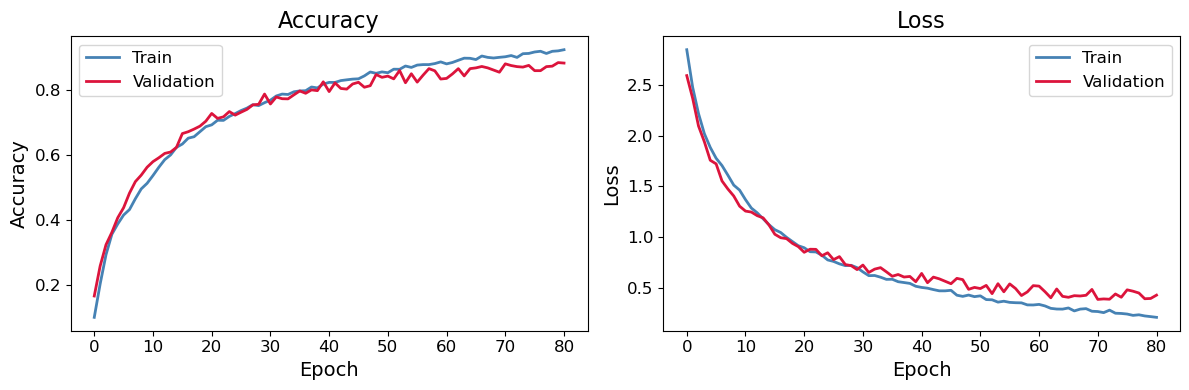

In [53]:
# Resultats
plot_history_categorical(history=history_small_cnn, n_rows=1, n_cols=2,
						max_fontsize=16, figure_size=(12, 4), metrics=['accuracy', 'loss'])

#### Model evaluation with the test set

In [52]:
# Evaluate the model with the test set
test_loss_small_cnn, test_acc_small_cnn = compiled_small_cnn_model.evaluate(test_data, verbose=2)

33/33 - 3s - loss: 0.3692 - accuracy: 0.8867 - 3s/epoch - 97ms/step


<strong>Comments:</strong>
<br><br>
According to the output of <code>model_small_cnn.summary()</code> the number of parameters to be trained is 112,437. This number of parameters is much smaller than in the case of the neural network of the previous exercise, without the convolutional layer. The number of parameters to be trained is smaller than in the case of a fully connected layer because, in a convolutional layer, a certain number of filters are applied to specific parts of the input instead of all neurons, which significantly reduces the number of parameters. (p. 159 of [1] and pp. 9 to 12 of [2]) For example, for the first convolutional layer, <code>(filter_height * filter_width * n_input_channels + 1) * n_output_channels</code> should be applied, that is, <code>(5 * 5 * 3 + 1) * 16 = 1,216</code>. If we do the corresponding calculations for each of the layers, we will obtain 112,437 parameters. (pp. 160 to 162 of [1] and pp. 30 to 32 of [2]).

The total time it took to train the model was about 2230 seconds (~37 minutes). It can be seen that the training and validation accuracy are increasing progressively, while the loss decreases. Training was stopped at epoch 81 due to the implementation of early stopping, which allows training to be stopped when there is no improvement in the validation accuracy, but rather when it starts to deteriorate, as explained on page 46 of [1]. Thus, the final values ​​of the accuracies are 0.9234 and 0.8824 for the training and validation sets, respectively, while the losses are 0.2161 and 0.4340, respectively.

Unlike the previous exercise, the use of the convolutional network in combination with different methods such as <i>early stopping</i> or <i>dropout</i> has allowed to reduce <i>overfitting</i> and obtain a good enough model that is able to generalize well (p. 35 of [1]). This can be seen in the evaluation of the model with the test set that returns an <i>accuracy</i> of 0.8867 and a <i>loss</i> of 0.3692 which are very similar to those of training and validation.

Finally, it should be noted that the use of more complex architectures such as AlexNet, LeNet-5 or VGG, among others, are convolutional neural networks designed specifically for image classification tasks and would certainly provide a more significant improvement in <i>accuracies</i> that could reach values ​​close to 0.99. [3]

<strong>References:</strong>
<br><br>
[1] Jordi Torres, Python Deep Learning. Practical Introduction with Keras and TensorFlow 2</i>, Marcombo (2020).

[2] Jordi Casas Roma and Anna Bosch Rue, <i>Fundamentals of convolutional neural networks</i>, UOC (2023).

[3] Jordi Casas Roma, <i>Architecture and applications of convolutional neural networks</i>, UOC (2023).
<br><br>

## 4. Autoencoders (2 points)

In the previous section we were able to observe that, using the appropriate type of networks, we can obtain better results by training a much lower number of parameters. This is because CNNs manage to extract the main features of the data provided (images in our case).

In this section we will observe this capacity from another point of view: that of **encoding and decoding an image**.

For this reason we will design an autoencoder that is capable of reducing the size of the input data but capturing the main features of the images to be able to carry out a good reconstruction.

We will start by externally rescaling the data that we will use, so that they are in the range (0,1), instead of doing it within the network as we did in the previous section:

In [10]:
# data rescaling
normalization_layer = Rescaling(1./255)

normalized_train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_data = validation_data.map(lambda x, y: (normalization_layer(x), y))

Furthermore, in an autoencoder, instead of using labels as the target (which is what is used in a classification problem), the images themselves should be used as the target of the network. Therefore, we will create a new training and validation database where the images themselves act as labels:

In [11]:
train_data_auto = normalized_train_data.map(lambda x, y: (x, x))
val_data_auto = normalized_val_data.map(lambda x, y: (x, x))

Let's check the structure of the new database:

In [ ]:
image_batch, label_batch = iter(train_data_auto).get_next()
print("The dimensions of a batch of images are: {}".format(image_batch.shape))
print("The dimensions of a batch of labels are: {}".format(label_batch.shape))

Les dimensions d'un batch d'imatges són: (32, 224, 224, 3)
Les dimensions d'un batch d'etiquetes són: (32, 224, 224, 3)


And that the data has the appropriate dynamic range:

In [ ]:
first_image = image_batch[0]
print("In the first image, the minimum and maximum values ​​are {} and {}, respectively."
      .format(np.min(first_image),np.max(first_image)))

En la primera imatge, els valors mínim i màxim són 0.0 i 1.0, respectivament.


### 4.1. Design and training the autoencoder

Once we have the data in the appropriate format, we will design the autoencoder. To do this, we will use the extractor block from the previous section as an encoder and reflect its structure in the decoder using the [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) and [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) layers of keras.

### Definition of the network for the autoencoder
A function for the autoencoder will be defined according to the requirements of the statement.

In [ ]:
def autoencoder(input_shape: tuple) -> tf.keras.models.Model:
    """
    Creation of the autoencoder with the characteristics defined
    previously.
    
    The code is based on the implementations found in:
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
    
    Parameters:
    -----------
    input_shape: tuple[int, int, int]
        Input dimensions.
    
    Returns:
    --------
    autoencoder: tf.keras.model.Models
        The model defined for the autoencoder.
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoding bloc
    x = Conv2D(filters=16, kernel_size=5, padding='same', activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    encoded = MaxPooling2D()(x)
    
    # Decoding bloc
    x = Conv2DTranspose(filters=64, kernel_size=3, padding='same', activation='relu')(encoded)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(filters=16, kernel_size=5, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    decoded = Conv2D(filters=3, kernel_size=3, padding='same', activation='sigmoid')(x)
    
    return Model(inputs, decoded)

In [16]:
autoencoder_model = autoencoder((224, 224, 3))

### Compiling the autoencoder

The same function defined in exercise 2 has been used. In this case, the *learning rate* has been defined as 0.001, the optimizer (*Adam*) and the loss as the *mean squared error* with *tf.keras.losses.MeanSquaredError*. Finally, the metric has been defined as *None* since it should not be monitored and, in addition, it is the default value (https://www.tensorflow.org/api_docs/python/tf/keras/Model).

In [ ]:
compiled_autoencoder_model = compile_model(model=autoencoder_model, learning_rate=0.001,
                                optimizer=tf.keras.optimizers.Adam,
                                loss=tf.keras.losses.MeanSquaredError,
                                metrics=None)

In [21]:
compiled_autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496 

### Autoencoder Training
The function created in exercise 2 will be used to train the autoencoder.

In [ ]:
# Register the training time
start_time = time.time()

history_autoencoder = train_nn_model(train_data_auto, val_data_auto, compiled_autoencoder_model, 
	epochs = 100, batch_size = 32, patience = 10, checkpoint_filepath = 'best_weights_autoencoder.h5')

# Finish time register
end_time = time.time() - start_time
print(f"The total training time is {end_time} seconds")

Epoch 1/100
230/230 [==============================] - 52s 184ms/step - loss: 0.0163 - val_loss: 0.0072
Epoch 2/100
230/230 [==============================] - 30s 128ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 3/100
230/230 [==============================] - 29s 124ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 4/100
230/230 [==============================] - 29s 125ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 5/100
230/230 [==============================] - 30s 126ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 6/100
230/230 [==============================] - 29s 123ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 7/100
230/230 [==============================] - 30s 127ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 8/100
230/230 [==============================] - 30s 127ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/100
230/230 [==============================] - 29s 125ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/100
230/230 [==============================] - 29s 124m

### Representation of loss

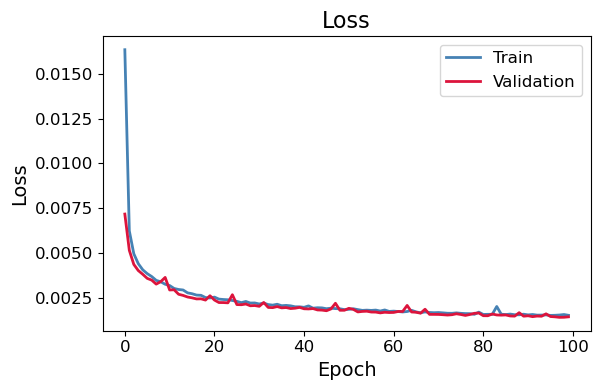

In [ ]:
plot_history_categorical(history=history_autoencoder, n_rows=1, n_cols=1,
						max_fontsize=16, figure_size=(6, 4), metrics=['loss'])

### 4.2. Autoencoder Evaluation

The evaluation of the obtained model can be done in this case both quantitatively (calculating the MSE between the original and reconstructed images of the test set) and qualitatively (showing original and reconstructed images).

### Data normalization and dataset generation *test_data_auto*

In [ ]:
normalized_test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

In [19]:
test_data_auto = normalized_test_data.map(lambda x, y: (x, x))

#### Checking the data structure for the test set

In [ ]:
image_batch, label_batch = iter(test_data_auto).get_next()
print("The dimensions of a batch of images are: {}".format(image_batch.shape))
print("The dimensions of a batch of labels are: {}".format(label_batch.shape))

Les dimensions d'un batch d'imatges és: (32, 224, 224, 3)
Les dimensions d'un batch d'etiquetas és: (32, 224, 224, 3)


### Model evaluation with the test set
The results will be evaluated with the test set and the images will also be reconstructed to be able to visualize them.

In [20]:
# Load the weights from the .h5 file
compiled_autoencoder_model.load_weights('/kaggle/working/best_weights_autoencoder.h5')

In [21]:
# Evaluate the model with the test set
test_loss_auto = compiled_autoencoder_model.evaluate(test_data_auto, verbose=2)

33/33 - 38s - loss: 0.0014 - 38s/epoch - 1s/step


In [24]:
# Evaluate the model with the test set and reconstructed images
def reconstruct_and_evaluate(
    autoencoder: tf.keras.models.Model, image_data: tf.data.Dataset
):
    """
    Reconstructs the images from the input dataset and calculates the metrics required (loss).
    
    The code is based on the implementations found in:
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
    - https://www.tensorflow.org/tutorials/generative/autoencoder
    
    Parameters:
    -----------
    test_images: tf.data.Dataset
        Dataset with the test images.
    reconstructed_images: tf.data.Dataset
        Dataset with the reconstructed images.
    n_images: int
        Number of images to plot.
    figure_size: tuple[int, int]
        Size of the figure to plot.
    max_fontsize: int
        Maximum font size to use in the plot.
    
    Returns:
    --------
    None
    """
    # Get the image data from the tensor and store it into a list
    test_images = []
    for image_batch, _ in image_data:
        for batch in range(len(image_batch)):
            test_images.append(image_batch[batch])
    
    # Make predictions using the autoencoder model
    reconstructed_images = autoencoder.predict(tf.stack(test_images))
    
    test_images = tf.stack(test_images)
    # Evaluate the loss (MSE) using the formula
    mse = np.mean(np.square(reconstructed_images - test_images))
    print(f"The loss (MSE) on the test set is {mse}.")
    return test_images, reconstructed_images

In [25]:
test_images, reconstructed_images = reconstruct_and_evaluate(compiled_autoencoder_model, test_data_auto)

33/33 [==============================] - 34s 1s/step
The loss (MSE) on the test set is 0.0014322545612230897.


It can be seen how the *loss* value calculated with the <code>.evaluate()</code> method returns the same result as using the own function that reconstructs the images and then applies the *MSE* formula using only the *numpy* library.

### Visualization of original and reconstructed images
Two functions will be created, one that takes the images from the test set and those reconstructed with the function *reconstruct_and_evaluate_on_test* and another that directly generates the reconstructed images from the dataset *test_data_auto*.

In [ ]:
def plot_original_reconstructed(
   test_images: tf.data.Dataset, reconstructed_images: tf.data.Dataset,
    n_images: int, figure_size: tuple, max_fontsize: int
) -> None:
    """
    Plots the original and reconstructed images for the input dataset.
    
    The code is based on the implementations found in:
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
    - https://www.tensorflow.org/tutorials/generative/autoencoder
    
    Parameters:
    -----------
    test_images: tf.data.Dataset
        Dataset with the test images.
    reconstructed_images: tf.data.Dataset
        Dataset with the reconstructed images.
    n_images: int
        Number of images to plot.
    figure_size: tuple[int, int]
        Size of the figure to plot.
    max_fontsize: int
        Maximum font size to use in the plot.
    
    Returns:
    --------
    None
    """
    # Plot the original and reconstructed images
    fig, axs = plt.subplots(2, n_images, figsize=figure_size)
    for i in range(n_images):
        axs[0, i].imshow(test_images[i])
        axs[1, i].imshow(reconstructed_images[i])
        axs[0, i].set_title('Original Image')
        axs[1, i].set_title('Reconstructed Image')
    plt.tight_layout()
    plt.show()

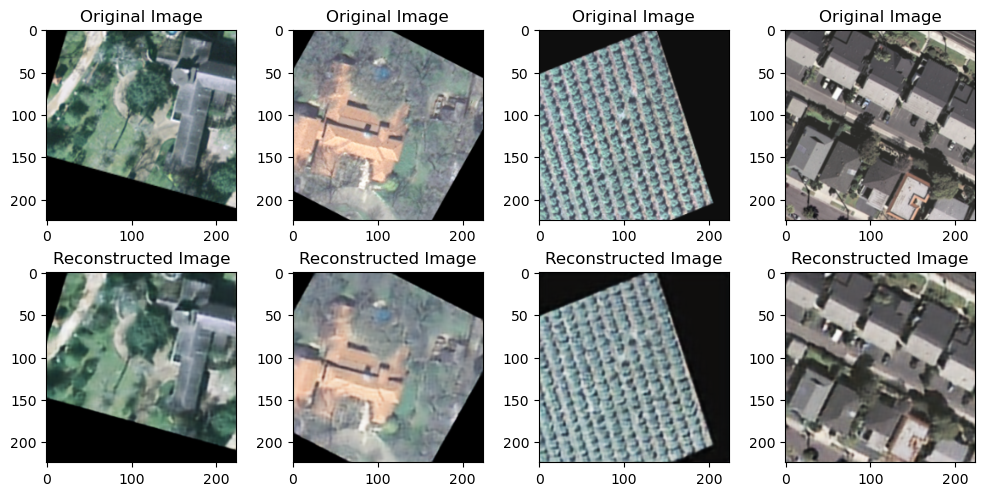

In [66]:
plot_original_reconstructed(test_images, reconstructed_images, n_images=4, 
                   figure_size=(10, 5), max_fontsize=10)

In [ ]:
def reconstruct_and_plot(
    autoencoder: tf.keras.models.Model, image_data: tf.data.Dataset,
    n_images: int, figure_size: tuple, max_fontsize: int
) -> None:
    """
    Plots the original and reconstructed images for the input dataset.
    
    The code is based on the implementations found in:
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
    - https://www.tensorflow.org/tutorials/generative/autoencoder
    
    Parameters:
    -----------
    autoencoder: tf.keras.model.Model
        Trained autoencoder model.
    image_data: tf.data.Dataset
        Dataset with the images to show.
    n_images: int
        Number of images to plot.
    figure_size: tuple[int, int]
        Size of the figure to plot.
    max_fontsize: int
        Maximum font size to use in the plot.
    
    Returns:
    --------
    None
    """
    # Get the image data from the tensor and store it into a list
    test_images = []
    for image_batch, _ in image_data:
        for batch in range(len(image_batch)):
            test_images.append(image_batch[batch])

    # Make predictions using the autoencoder model
    reconstructed_images = autoencoder.predict(tf.stack(test_images))

    # Plot the original and reconstructed images
    fig, axs = plt.subplots(2, n_images, figsize=figure_size)
    for i in range(n_images):
        axs[0, i].imshow(test_images[i])
        axs[1, i].imshow(reconstructed_images[i])
        axs[0, i].set_title('Original Image')
        axs[1, i].set_title('Reconstructed Image')
    plt.tight_layout()
    plt.show()

33/33 [==============================] - 1s 20ms/step


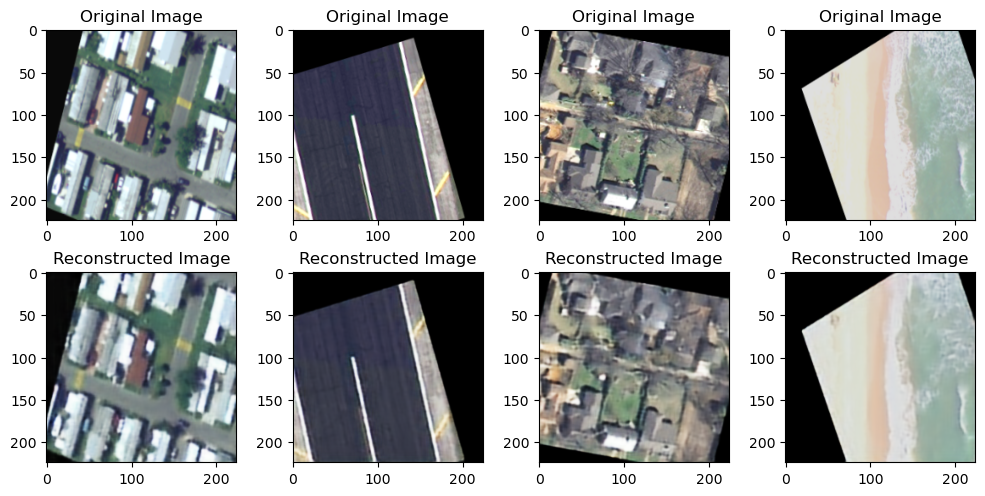

In [64]:
reconstruct_and_plot(autoencoder=compiled_autoencoder_model, 
                   image_data=test_data_auto, n_images=4, 
                   figure_size=(10, 5), max_fontsize=10)

<strong>Comments:</strong>
<br><br>
According to the output of <code>compiled_autoencoder_model.summary()</code> the number of parameters to train is 92,995, taking into account the encoder and decoder. The total time it took to train the autoencoder was about 3343 seconds (~56 minutes).

The training stopped at <i>epoch</i> 100. Therefore, <i>early stopping</i> was not activated. Thus, the final values ​​of the <i>loss</i> are 0.0015 and 0.0014, respectively. Since the metric to evaluate the loss is the <i>Mean Squared Error</i>, everything would seem to indicate that the model is good enough to be able to reconstruct the images with a high similarity to the originals, since the lower the value, the better. [1] In fact, this is what can be seen in the visual representation of the images, that is, the reconstructed images are practically identical to the original ones. In addition, the <i>loss</i> of the test is also very small, 0.0015, which indicates that the autoencoder is able to generalize very well. In conclusion, the reconstruction made by the autoencoder can be considered very good and can reproduce the original images with high quality.

The compression ratio of the autoencoder can be calculated by comparing the number of input parameters with the number of output parameters for one of its elements, in this case the encoder. [2] Thus, the initial size of the images is <code>(224, 224, 3)</code>, while the encoded image has a size of <code>(28, 28, 64)</code>. Therefore, the number of initial and final parameters is <code>224 * 224 * 3 = 150,528</code> and <code>28 * 28 * 64 = 50,176</code>. Dividing both values ​​gives 3, so the compression ratio is <code>3:1</code>, meaning the encoded images have one-third of the initial parameters.

<strong>References:</strong>

[1] Aurélien Géron, <i>Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow</i>, O'Reilly (2023).

[2] https://en.wikipedia.org/wiki/Data_compression_ratio

## 5. VGG16 Network and Transfer Learning (2 points)

Deep convolutional neural networks provide us with the possibility of improving the learning capacity of a model. Some common architectures can include hundreds of convolutional layers. However, training these architectures from scratch can be costly in terms of both time and resources, in addition to requiring quite large data sets.

### 5.1. Transfer Learning
In this section, we will apply [transfer learning](https://keras.io/guides/transfer_learning/) in order to save us some of this training. This methodology consists of taking advantage of the weights of a model trained on another database and for another task. Specifically, we will use the [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) model pre-trained on [Imagenet](http://www.image-net.org/), and adapt it to classify the 21 categories of our database. In the VGG16 version of keras there is the option to load the weights trained on Imagenet without the 3 fully connected layers of the final part of the network (option <code>include_top = False</code>), we will replace these 3 layers and retrain the set with the rest of the frozen weights.

To reuse the model correctly, it is necessary to pre-process the data as it was done during training on the original database. Keras makes it easy for us to apply normalization in the case of pre-trained models; for the case of VGG16 review the documentation of [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input) (note that the function is applied on images with a dynamic range of 0 to 255).

### Load the data
The data from exercise 1 (*train_data, validation_data and test_data*) will be processed to fit the *VGG-16* algorithm. A function will also be created to check the dynamic range of the images.

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Define the preprocessing function to apply to each image in the dataset
def preprocess_data(inputs, targets):
    preprocessed_data = preprocess_input(inputs)
    return preprocessed_data, targets

# Use the map function to apply the preprocessing function to the datasets
train_vgg16 = train_data.map(preprocess_data)
validation_vgg16 = validation_data.map(preprocess_data)
test_vgg16 = test_data.map(preprocess_data)

In [12]:
def check_dynamic_range(input_data: tf.data.Dataset, n_images: int) -> None:
    """
    Checks the dynamic range of the input tensor.
    
    Parameters:
    -----------
    input_data: tf.data.Dataset
        Dataset with the images to check the dynamic range.
    n_images: int
        Number of images to check the dynamic range.
    
    Returns:
    --------
    None
    """
    # Get the image data of at most n_images from the tensor and store it into a list
    list_images = []
    for image_batch, _ in input_data.take(n_images):
        for batch in range(len(image_batch)):
            list_images.append(image_batch[batch])
    
    # Calculate the dynamic range for the first image
    for i in range(list_images[0].shape[-1]):
        channel_min = tf.reduce_min([tf.reduce_min(img[:, :, i]) for img in list_images])
        channel_max = tf.reduce_max([tf.reduce_max(img[:, :, i]) for img in list_images])
        print("Channel {}: min = {}, max = {}".format(i, channel_min, channel_max))

In [12]:
check_dynamic_range(train_vgg16, 1)

Channel 0: min = -103.93900299072266, max = 151.06100463867188
Channel 1: min = -116.77899932861328, max = 138.22100830078125
Channel 2: min = -123.68000030517578, max = 131.32000732421875


In [14]:
for image_batch, labels_batch in train_vgg16:
	print(image_batch.shape)
	print(labels_batch.shape)
	break

(32, 224, 224, 3)
(32, 21)


You can see how the dynamic range of the images has been centered at 0 without scaling as explained in https://keras.io/api/applications/vgg/. Therefore, they will need to be rescaled in order to train the algorithm.

In [13]:
def load_pretrained_vgg16(
    input_shape: tuple, weights: str, include_top: bool, trainable_layers: bool
) -> tf.keras.models.Model:
    """
    Loads the pretrained VGG16 model.
    
    The code is based on the implementations found in:
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
    - https://www.tensorflow.org/guide/keras/transfer_learning
    
    Parameters:
    -----------
    input_shape: tuple[int, int, int]
        Shape of the input images.
    weights: str
        Name of the pretrained dataset to use the weights from.
    include_top: bool
        Boolean to decide if the last layers of the neural network are removed or not.
    trainable_layers: bool
        Boolean to decide if the weights of the model layers are frozen or not.
    
    Returns:
    --------
    tf.keras.models.Model
        Pretrained VGG16 model.
    """
    pretrained_vgg16 = VGG16(weights='imagenet', include_top=include_top, input_shape=input_shape)
    
    # Freeze all layers of the pretrained model
    for layer in pretrained_vgg16.layers:
        layer.trainable = trainable_layers
    
    return pretrained_vgg16

In [14]:
pretrained_vgg16 = load_pretrained_vgg16(input_shape=(224, 224, 3), weights='imagenet', include_top=False, trainable_layers=False)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
pretrained_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

You can see how all the layers of the pre-trained model have frozen weights as they appear as *Non-trainable params*.

### Network Definition
The modification of the *VGG-16* model will be created according to the criteria of the statement. A data rescaling layer in the range [-1, 1] will also be included, since this will make training more efficient than using data with a larger dynamic range, as explained in https://keras.io/guides/transfer_learning/ and on page 15 of *Introduction to Deep Learning* by Jordi Casas Roma, UOC (2023).

In [ ]:
def vgg16_model(pretrained_model: tf.keras.models.Model, input_shape: tuple, training: bool) -> tf.keras.models.Model:
    """
    Create a VGG16 models by adding the last 3 layers according to the requirements of the exercise.
    
    The code is based on the implementations found in:
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
    - https://keras.io/guides/transfer_learning/
    - https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning
    
    Parameters:
    -----------
    pretrained_model: tf.keras.models.Model
        Instance with the pretrained VGG16 model.
    input_shape: tuple[int, int, int]
        Input dimensions.
    training: bool
        Sets the model in inference mode to prevent updating the weights on BatchNormalization layers.
    
    Returns:
    --------
    tf.keras.models.Model
        Modified VGG16 model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Rescale the inputs to a range between -1 and 1
    # Source: https://keras.io/guides/transfer_learning/
    x = Rescaling(1./127.5, offset=-1)(inputs)
    
    # Sets the pretrained_model in inference mode
    base_model = pretrained_model(x, training=training)
    
    # Add the fully connected layers required to the pretrained VGG16 model by flattening the outputs
    x = Flatten()(base_model)
    x = Dense(50, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    output = Dense(21, activation='softmax')(x)
    return Model(inputs, outputs=output)

In [40]:
modified_vgg16 = vgg16_model(pretrained_vgg16, input_shape=(224, 224, 3), training=False)

In [41]:
modified_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 50)                1254450   
                                                                 
 dense_7 (Dense)             (None, 20)                1020      
                                                                 
 dense_8 (Dense)             (None, 21)                441 

The layers that have been added to the model can be trained since in this case they do not have defined weights.

### Compiling the VGG16 model

To compile the network, the function created in exercise 2 will be used with the learning rate of 0.0001, the Adam optimizer, the *loss* will be the *CategoricalCrossentropy* and the tracking metric, the *accuracy*.

In [ ]:
compiled_vgg16 = compile_model(model=modified_vgg16, learning_rate=0.0001,
							optimizer=tf.keras.optimizers.Adam,
							loss=tf.keras.losses.CategoricalCrossentropy,
							metrics=['accuracy'])

### Network Training
To train the network, the function created in exercise 2 will be used.

In [43]:
# Register the training time
start_time = time.time()

# Train the model
history_vgg16 = train_nn_model(train_vgg16, validation_vgg16, compiled_vgg16, 
	epochs = 100, batch_size = 32, patience = 10, checkpoint_filepath = 'best_weights_vgg16.h5')

# Finish time register
end_time = time.time() - start_time
print(f"The total training time is {end_time} seconds")

Epoch 1/100
230/230 [==============================] - 46s 190ms/step - loss: 2.1295 - accuracy: 0.3695 - val_loss: 1.5085 - val_accuracy: 0.6267
Epoch 2/100
230/230 [==============================] - 55s 238ms/step - loss: 1.0471 - accuracy: 0.7683 - val_loss: 0.9256 - val_accuracy: 0.7771
Epoch 3/100
230/230 [==============================] - 45s 193ms/step - loss: 0.5693 - accuracy: 0.8943 - val_loss: 0.6768 - val_accuracy: 0.8290
Epoch 4/100
230/230 [==============================] - 55s 236ms/step - loss: 0.3537 - accuracy: 0.9385 - val_loss: 0.5673 - val_accuracy: 0.8495
Epoch 5/100
230/230 [==============================] - 45s 192ms/step - loss: 0.2399 - accuracy: 0.9646 - val_loss: 0.5006 - val_accuracy: 0.8624
Epoch 6/100
230/230 [==============================] - 44s 189ms/step - loss: 0.1688 - accuracy: 0.9826 - val_loss: 0.4649 - val_accuracy: 0.8705
Epoch 7/100
230/230 [==============================] - 45s 192ms/step - loss: 0.1222 - accuracy: 0.9903 - val_loss: 0.4349 -

### Evaluation of results

In [ ]:
test_loss, test_acc = compiled_vgg16.evaluate(test_vgg16)

33/33 [==============================] - 5s 136ms/step - loss: 0.3680 - accuracy: 0.8790


### Representation of results

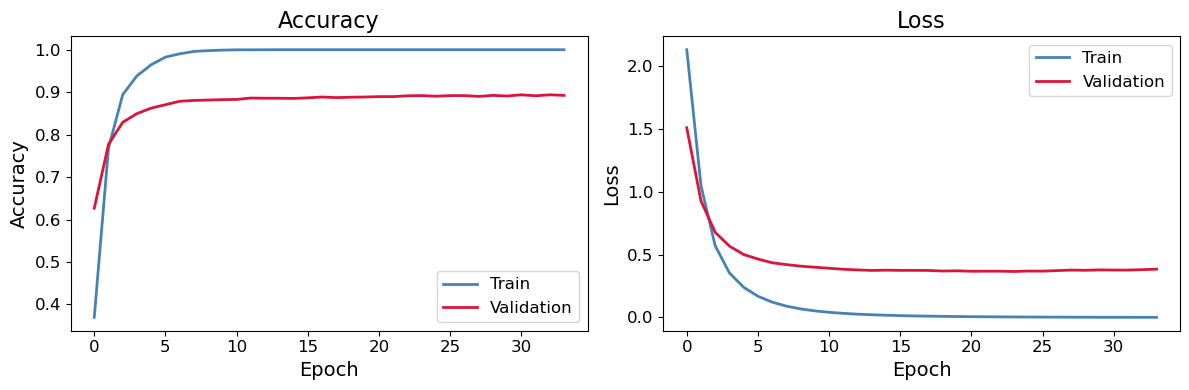

In [55]:
# Plot del training loss i l'accuracy
plot_history_categorical(history=history_vgg16, n_rows=1, n_cols=2,
						max_fontsize=16, figure_size=(12, 4), metrics=['accuracy', 'loss'])

<strong>Comments:</strong>
<br>
According to the output of <code>modified_vgg16.summary()</code> the total parameters are 15,970,599, while only 1,255,911 will be trained, which correspond to the parameters of the layers that have been added to the pre-trained model. Thus, the remaining 14,714,688 parameters that correspond to the pre-trained model are frozen as intended.

The total time it took to train the model was about 1992 seconds (~34 minutes), a little faster than the CNN network in exercise 3. It can be seen how the training and validation <i>accuracy</i> progressively increase, while the <i>loss</i> decreases. The training has stopped at <i>epoch</i> 34 due to the implementation of <i>early stopping</i> which allows stopping the training when there is no improvement in the validation accuracy, but rather that it starts to get worse, as explained on page 46 of [1]. Thus, the final values ​​of the <i>accuracies</i> are 1.0 and 0.8924 for the training and validation sets, respectively, while the <i>losses</i> are 0.001 and 0.3842, respectively. These results are better than those obtained with the small CNN network and in fact the achievement of these values ​​has been much faster; in epoch 3 the accuracy was already 0.82. This is due to the complexity of the <i>VGG-16</i> network and the number of convolutional layers that allow learning the different features of the images well and the pre-training with the data from the <i>ImageNet</i> dataset. (pp. 15-17 of [1])

Despite having used early stopping, it seems that there is still some difference between the accuracies that could indicate a bit of overfitting and, therefore, the model might not generalize well (pp. 35 of [1]). One way to avoid or minimize overtraining would be to use regularization techniques such as L2 or L1 regularization, modify the probability value in the dropout layer, artificially increase the data set, etc. (pp. 45 to 48 of [1]). Another possibility would be to do as indicated in [4] and in the following section, that is, to do a <i>fine-tuning</i> of the pre-trained network by unfreezing all the weights with a small <i>learning rate</i> for a few epochs.

The evaluation of the model with the test set returns an accuracy of 0.8790 and a loss of 0.3680 which are very similar to those of the validation set. In addition, they are also very similar to the values ​​obtained with the simple CNN network (<i>accuracy</i> of 0.8867 and a <i>loss</i> of 0.3692).

Finally, it should be noted that the results obtained with the modified VGG-16 model do not seem entirely good since the accuracy on the validation and test sets is relatively lower than that of the training set. This indicates that the trained model, despite being good, may not be able to correctly classify all the images. In order to improve the results, it would be advisable to try the methods mentioned above to control overfitting or implement other neural networks such as some of the variants of <i>ResNet</i>, which could offer an improvement over the results observed here, since as explained in [5] they obtain better performance than <i>VGG-16</i> when classifying images despite having a lower number of filters and lower complexity.

<strong>References:</strong>
<br>
[1] Jordi Torres, <i>Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2</i>, Marcombo (2020).

[2] Jordi Casas Roma and Anna Bosch Rue, <i>Fundamentos de las redes neuronales convolucionales</i>, UOC (2023).

[3] Jordi Casas Roma, <i>Arquitectura y aplicaciones de las redes neuronales convolucionales</i>, UOC (2023).

[4] https://www.tensorflow.org/guide/keras/transfer_learning

[5] Kaiming He, Ziangyu Zhang, Shaoqing Ren, Jian Sun, <i>Deep Residual Learning for Image Recognition</i>, arXiv:1512.03385 (2015).

### 5.2. Fine-tuning
A common technique, especially when the network used is not excessively large (as is the case with VGG16), to improve the results of <i>transfer learning</i> is the so-called <i>fine-tuning</i>, which consists of retraining the entire network for a few epochs and with a very small <i>learning rate</i>.

### Model definition for fine tuning
In this section, we will use the functions created earlier (<code>load_pretrained_vgg16</code> and <code>vgg16_model</code>). To unfreeze the weights of the pretrained *VGG-16* model, we will use the parameter <code>trainable_layers=True</code>.

In [ ]:
pretrained_vgg16_finetuning = load_pretrained_vgg16(input_shape=(224, 224, 3), weights='imagenet', include_top=False, trainable_layers=True)
modified_vgg16_finetuning = vgg16_model(pretrained_vgg16_finetuning, input_shape=(224, 224, 3), training=False)

In [17]:
modified_vgg16_finetuning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 21)                441   

In this case, you can see that all parameters are trainable because the weights of the pre-trained model have been unlocked. However, the weights of the *BatchNormalization* layers will be maintained when using *training=False*.

### Compilation of the VGG16 model for fine tuning

To compile the network, the function created in exercise 2 will be used with the learning rate of 0.00001, the Adam optimizer, the *loss* will be the *CategoricalCrossentropy* and the tracking metric, the *accuracy*.

In [ ]:
compiled_vgg16_finetuning = compile_model(model=modified_vgg16_finetuning, learning_rate=0.00001,
							optimizer=tf.keras.optimizers.Adam,
							loss=tf.keras.losses.CategoricalCrossentropy,
							metrics=['accuracy'])

It is necessary to load the weights of the previously trained model because here we only want to refine the model.

In [19]:
# Load the weights from the .h5 file
compiled_vgg16_finetuning.load_weights('/kaggle/working/best_weights_vgg16.h5')

### Network Training
To train the network, the function created in exercise 2 will be used and only for 10 epochs.

In [20]:
# Register the training time
start_time = time.time()

# Train the model
history_vgg16_finetuning = train_nn_model(train_vgg16, validation_vgg16, compiled_vgg16_finetuning, 
	epochs = 10, batch_size = 32, patience = 10, checkpoint_filepath = 'best_weights_vgg16_finetuning.h5')

# Finish time register
end_time = time.time() - start_time
print(f"The total training time is {end_time} seconds")

Epoch 1/10
230/230 [==============================] - 93s 332ms/step - loss: 0.0124 - accuracy: 0.9971 - val_loss: 0.4121 - val_accuracy: 0.8962
Epoch 2/10
230/230 [==============================] - 60s 256ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.3618 - val_accuracy: 0.9076
Epoch 3/10
230/230 [==============================] - 60s 256ms/step - loss: 2.7116e-04 - accuracy: 1.0000 - val_loss: 0.3584 - val_accuracy: 0.9105
Epoch 4/10
230/230 [==============================] - 70s 301ms/step - loss: 1.4526e-04 - accuracy: 1.0000 - val_loss: 0.3651 - val_accuracy: 0.9100
Epoch 5/10
230/230 [==============================] - 59s 253ms/step - loss: 1.0109e-04 - accuracy: 1.0000 - val_loss: 0.3715 - val_accuracy: 0.9124
Epoch 6/10
230/230 [==============================] - 59s 253ms/step - loss: 7.4357e-05 - accuracy: 1.0000 - val_loss: 0.3776 - val_accuracy: 0.9133
Epoch 7/10
230/230 [==============================] - 59s 252ms/step - loss: 5.6671e-05 - accuracy: 1.0000 - val_l

### Evaluation of results

In [ ]:
test_loss, test_acc = compiled_vgg16_finetuning.evaluate(test_vgg16)

33/33 [==============================] - 11s 297ms/step - loss: 0.4006 - accuracy: 0.9067


### Representation of results

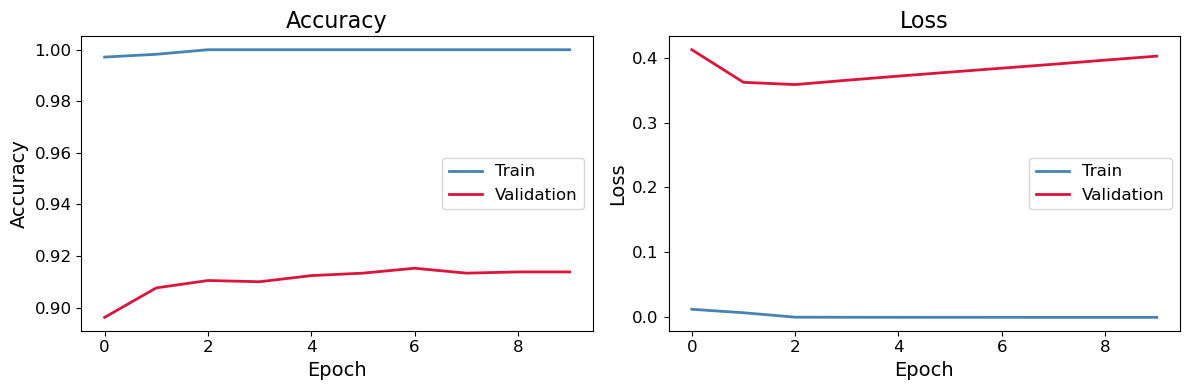

In [22]:
# Plot del training loss i l'accuracy
plot_history_categorical(history=history_vgg16_finetuning, n_rows=1, n_cols=2,
						max_fontsize=16, figure_size=(12, 4), metrics=['accuracy', 'loss'])

<strong>Comments:</strong>
<br>
According to the output of <code>modified_vgg16_finetuning.summary()</code> the total number of parameters is 15,970,599 and in this case all of them will be trained, but the <code>training=False</code> parameter has been used to run the model in inference mode and thus avoids updating the statistics of the <code>BatchNormalization</code> layers and resetting all the learning done so far. [1]

The total time it took to train the model was about 660 seconds (~11 minutes). It can be seen that the validation <i>accuracy</i> has increased slightly, while the <i>loss</i> has decreased slightly. Thus, the final values ​​of the <i>accuracies</i> are 1.0 and 0.9138 for the training and validation sets, respectively, while the <i>losses</i> are 2.83e-5 and 0.4022, respectively. This represents a slight improvement over the original results, which is the goal of fine tuning, refining the results of the pre-trained model with the new dataset.

The evaluation of the model with the test set returns an accuracy of 0.9067 and a loss of 0.4006 which are very similar to the validation ones. In addition, they are also slightly better than the values ​​obtained with the unrefined network (<i>accuracy</i> of 0.8790 and a <i>loss</i> of 0.3680).

Finally, it should be noted that the results obtained with the modified and refined VGG-16 model provide a slight improvement in the quality of the metrics compared to the small CNN network of exercise 3. This could be due to the need to refine the model for a few more epochs to achieve better results or to directly train the neural network with the current dataset. However, what transfer learning has achieved is to greatly reduce the training time that would have taken to train a network as complex as VGG-16 (with 15 million parameters) compared to the small CNN network (approximately 112,000 parameters). This is the main advantage of transfer learning beyond the improvement in metrics, that is, the reuse of models to train others that perform similar tasks. This is very common in image recognition and <i>deep learning</i> tasks because training neural networks requires a lot of computational resources that are often not available to everyone. [3] In order to further improve the results, apart from the options mentioned, it would be advisable to try other methods to reduce overtraining such as <i>data augmentation</i> or modify the training parameters such as the learning rate or modify the structure of the neural network by adding additional layers or even using other pre-trained models such as <i>ResNet</i> or <i>EfficientNet</i>. [2-5]

<strong>References:</strong>
<br>
[1] https://www.tensorflow.org/guide/keras/transfer_learning

[2] Jordi Casas Roma and Anna Bosch Rue, <i>Fundamentos de las redes neuronales convolucionales</i>, UOC (2023).

[3] Jordi Casas Roma, <i>Architecture and applications of convolutional neural networks</i>, UOC (2023).

[4] Kaiming He, Ziangyu Zhang, Shaoqing Ren, Jian Sun, <i>Deep Residual Learning for Image Recognition</i>, arXiv:1512.03385 (2015).

[5] Mingxing Tan, Quoc V. Le, <i>EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks</i>, arXiv:1905.11946 (2019).

## 6. Improving results (1 point)

In this last section, the student is given the freedom to achieve, by designing their own network, better results in the classification task.

The justification for the choices made will be assessed.

### Network architecture design, compilation and training

In this section, the network architecture will be defined and a justification will be made for it.

In [ ]:
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#### Model with Batch Normalization before activation

In [10]:
def cnn_model_bn_act(input_shape: tuple) -> tf.keras.Model:
    """
    Creates a CNN model with Batch Normalization layers before the activation.
    
    The code is based on the implementations found in:
    - https://www.tensorflow.org/tutorials/quickstart/advanced
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).

    Parameters:
    -----------
    input_shape: tuple[int, int, int]
        The shape of the input tensor (height, width, channels).

    Returns:
    --------
    tf.keras.Model
        CNN model.
    """
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)
    x = Conv2D(filters=16, kernel_size=3, padding='same')(x) # , activation='relu'
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=512, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    output = Dense(units=21, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=output)
    return model


In [11]:
model_cnn_bn_act = cnn_model_bn_act(input_shape=(224, 224, 3))
model_cnn_bn_act.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                           

#### Model with Batch Normalization after activation

In [ ]:
def cnn_model_act_bn(input_shape: tuple) -> tf.keras.Model:
    """
    Creates a CNN model with the previous requirements.
    
    The code is based on the implementations found in:
    - https://www.tensorflow.org/tutorials/quickstart/advanced
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).

    Parameters:
    -----------
    input_shape: tuple[int, int, int]
        The shape of the input tensor (height, width, channels).

    Returns:
    --------
    tf.keras.Model
        CNN model.
    """
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)
    x = Conv2D(filters=16, kernel_size=3, padding='same')(x) # , activation='relu'
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=512, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    output = Dense(units=21, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=output)
    return model


In [14]:
model_cnn_act_bn = cnn_model_act_bn(input_shape=(224, 224, 3))
model_cnn_act_bn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640  

5,000 / 5,000
#### Justification of the two networks used
The choice of such a complex network has been made for the following reasons. First, the deeper the neural network, the more capable it is of recognizing and extracting complicated features and identifying complex patterns in the input images and, therefore, this should help increase the accuracy of the classification. (p. 25 of [1]) On the other hand, the gradual increase in the number of filters from 16 to 512 has been carried out because each layer increases the complexity of the features to be detected. (p. 28 of [1]) That is, the first layers detect simpler features of the images such as contours, while the deeper layers detect more complex elements such as a door of a house, a tree, etc. In addition, a larger number of filters allows for a greater number of high- and low-level features to be captured, and therefore the model can learn to better discern the representations of the images, which should benefit generalization and improve accuracy. [2]

The use of <i>Batch Normalization</i> is another important element to improve the performance of convolutional networks, since what it does is normalize the layer inputs to end up with inputs centered around 0 and with a standard deviation close to 1. Instead of doing this for the entire data set at once, it is done in small <i>batches</i> with the aim of minimizing the deviation of the internal covariance during training. [3] This allows for improved training speed and generalization capacity, since the inputs have values ​​closer to each other, therefore the network is able to better learn general features of the images instead of memorizing what the data is like. Furthermore, it allows the use of higher learning rates as it counteracts the problem of the explosion and/or disappearance of the gradient during backpropagation. (page 20 of [4]) This is because the scale of the data does not affect the Jacobian of each layer and, consequently, the propagation of the gradient. [3] Finally, it also has a regularization function since the obtaining of deterministic values ​​is avoided thanks to the use of <i>batches</i>. [3] An important point to take into account is that the <i>Batch Normalization</i> layer is usually included between the convolution and activation layers to ensure that the resulting distribution of the activation layer is always in the same range of values. [3] However, there has recently been some debate regarding which solution is better and, therefore, both options will be explored. [5]

Thirdly, the use of the ReLU activation function helps to provide nonlinearity to the model so that it can better learn the complex relationships between the inputs and outputs of each convolutional network. In addition, being a function that assigns zeros to all negative values, it helps to reduce the computational cost of the convolutional layers and makes training more efficient. Finally, it is also beneficial to combat gradient vanishing and train the model faster without affecting its performance. [1, 6]

Fourthly, the <i>MaxPooling</i> layer is used, which allows to reduce the dimensions of the layer by calculating the maximum value of each "section" of the layer by applying a filter, by default 2x2. Although it will depend on the type of problem, this layer is usually applied after the activation layer since the activation layer allows to better capture the complex relationships identified with the convolution layer. Therefore, if the <i>MaxPooling</i> layer is placed before, this capacity of the activation layer could be limited. [7]

The <i>GlobalAveragePooling2D</i> layer has a similar effect to the previous layer, that is, it reduces the dimensions of the layer, but in this case the average value is calculated at all spatial positions. This allows to significantly reduce the number of parameters to be trained, making the models more efficient. In addition, this also has a regularization effect, making the models less prone to overtraining. [8]

The fully connected layer of 1024 units has been used to connect the <i>GlobalAveragePooling2D</i>. The number of units has been chosen taking as an example exercise 3. The larger the number of neurons, the better the features learned by the convolutional layers can be recognized to make predictions. However, if the number of units is too large, overfitting will also be introduced. [1, 4, 9, 10] For this reason, a <i>Dropout</i> layer has been introduced that randomly deactivates a certain number of neurons at each iteration so that the model learns different paths to recognize patterns. [1] Finally, the last layer of 21 neurons has the objective of predicting each of the categories with a probability defined by the <i>softmax</i> activation function. [1]

<strong>References:</strong>
<br>
[1] Jordi Casas Roma i Anna Bosch Rue, <i>Fundamentos de las redes neuronales convolucionales</i>, UOC (2023).  

[2] Karen Simonyan, Andrew Zisserman, <i>Very Deep Convolutional Networks for Large-Scale Image Recognition</i>, arXiv:1409.1556 (2014).

[3] Sergei Ioffe, Christian Szegedy, <i>Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift</i>, arXiv:1502.03167 (2015).

[4] Jordi Casas Roma, <i>Las redes neuronales artificiales</i>, UOC (2023).

[5] https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout

[6] Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton, <i>ImageNet Classification with Deep Convolutional Neural Networks</i>, NeurIPS Proceedings (2012).

[7] https://medium.com/@pranaypokala/pooling-layer-in-cnn-c8e128e869d8

[8] Min Lin, Qiang Chen, Shuicheng Yan, <i>Network in Network</i>, arXiv:1312.4400 (2014).

[9] Jordi Casas Roma, <i>Arquitectura y aplicaciones de las redes neuronales convolucionales</i>, UOC (2023).

[10] Jordi Torres, <i>Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2</i>, Marcombo (2020).

### Compilation of models with Batch Normalization before and after the activation layer

#### Model with Batch Normalization before activation

In [ ]:
compiled_cnn_improved_bn_act = compile_model(model=model_cnn_bn_act, learning_rate=0.001,
							optimizer=tf.keras.optimizers.Adam,
							loss=tf.keras.losses.CategoricalCrossentropy,
							metrics=['accuracy'])

#### Model with Batch Normalization after activation

In [ ]:
compiled_cnn_improved_act_bn = compile_model(model=model_cnn_act_bn, learning_rate=0.001,
							optimizer=tf.keras.optimizers.Adam,
							loss=tf.keras.losses.CategoricalCrossentropy,
							metrics=['accuracy'])

### Training the models with Batch Normalization before and after the activation layer

#### Model with Batch Normalization before activation

In [13]:
# Register the training time
start_time = time.time()

# Train the model
history_cnn_improved_bn_act = train_nn_model(train_data, validation_data, compiled_cnn_improved_bn_act, 
	epochs = 100, batch_size = 32, patience = 10, checkpoint_filepath = 'best_weights_cnn_improved_bn_act.h5')

# Finish time register
end_time = time.time() - start_time
print(f"The total training time is {end_time} seconds")

Epoch 1/100
230/230 [==============================] - 52s 172ms/step - loss: 2.2069 - accuracy: 0.3230 - val_loss: 3.2194 - val_accuracy: 0.1519
Epoch 2/100
230/230 [==============================] - 26s 112ms/step - loss: 1.5323 - accuracy: 0.4950 - val_loss: 1.7708 - val_accuracy: 0.4595
Epoch 3/100
230/230 [==============================] - 26s 113ms/step - loss: 1.1993 - accuracy: 0.6064 - val_loss: 1.2002 - val_accuracy: 0.5957
Epoch 4/100
230/230 [==============================] - 27s 113ms/step - loss: 0.9723 - accuracy: 0.6781 - val_loss: 1.7398 - val_accuracy: 0.4981
Epoch 5/100
230/230 [==============================] - 26s 110ms/step - loss: 0.7862 - accuracy: 0.7385 - val_loss: 0.9265 - val_accuracy: 0.7067
Epoch 6/100
230/230 [==============================] - 26s 112ms/step - loss: 0.6450 - accuracy: 0.7835 - val_loss: 1.0100 - val_accuracy: 0.6919
Epoch 7/100
230/230 [==============================] - 26s 112ms/step - loss: 0.5361 - accuracy: 0.8246 - val_loss: 1.1129 -

#### Model with Batch Normalization after activation

In [19]:
# Register the training time
start_time = time.time()

# Train the model
history_cnn_improved = train_nn_model(train_data, validation_data, compiled_cnn_improved_act_bn, 
	epochs = 100, batch_size = 32, patience = 10, checkpoint_filepath = 'best_weights_cnn_improved_act_bn.h5')

# Finish time register
end_time = time.time() - start_time
print(f"The total training time is {end_time} seconds")

Epoch 1/100
230/230 [==============================] - 29s 112ms/step - loss: 2.3768 - accuracy: 0.2697 - val_loss: 1.9140 - val_accuracy: 0.3576
Epoch 2/100
230/230 [==============================] - 27s 117ms/step - loss: 1.8044 - accuracy: 0.4046 - val_loss: 1.6189 - val_accuracy: 0.4400
Epoch 3/100
230/230 [==============================] - 28s 121ms/step - loss: 1.5442 - accuracy: 0.4801 - val_loss: 1.7434 - val_accuracy: 0.4271
Epoch 4/100
230/230 [==============================] - 26s 111ms/step - loss: 1.4204 - accuracy: 0.5144 - val_loss: 1.2470 - val_accuracy: 0.5729
Epoch 5/100
230/230 [==============================] - 33s 143ms/step - loss: 1.2794 - accuracy: 0.5562 - val_loss: 1.2543 - val_accuracy: 0.5871
Epoch 6/100
230/230 [==============================] - 28s 114ms/step - loss: 1.1624 - accuracy: 0.6046 - val_loss: 1.1083 - val_accuracy: 0.6448
Epoch 7/100
230/230 [==============================] - 26s 110ms/step - loss: 0.9903 - accuracy: 0.6580 - val_loss: 0.9290 -

### Model evaluation

#### Model with Batch Normalization before activation

In [ ]:
test_loss, test_acc = compiled_cnn_improved_bn_act.evaluate(test_data)

33/33 [==============================] - 3s 63ms/step - loss: 0.3451 - accuracy: 0.9114


#### Model with Batch Normalization after activation

In [ ]:
test_loss, test_acc = compiled_cnn_improved_act_bn.evaluate(test_data)

33/33 [==============================] - 5s 113ms/step - loss: 0.4423 - accuracy: 0.8943


### Representation of results

#### Model with Batch Normalization before activation

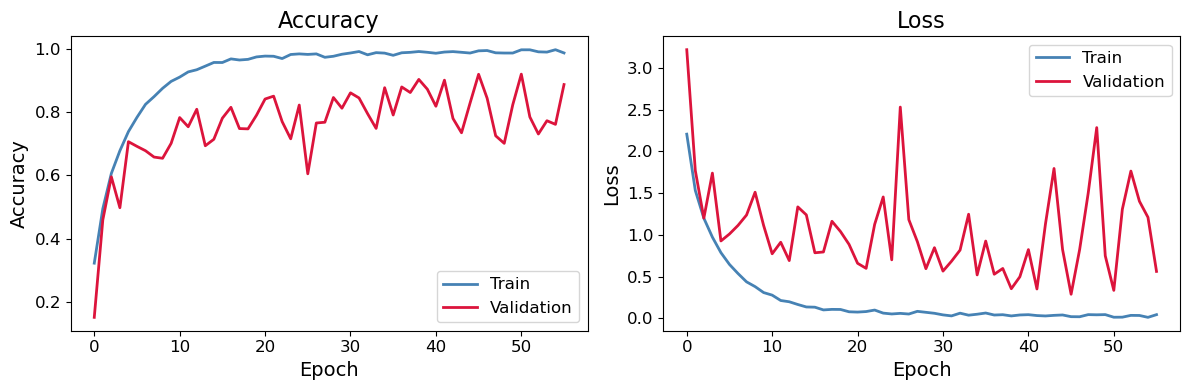

In [ ]:
plot_history_categorical(history=history_cnn_improved_bn_act, n_rows=1, n_cols=2,
						max_fontsize=16, figure_size=(12, 4), metrics=['accuracy', 'loss'])

#### Model with Batch Normalization after activation

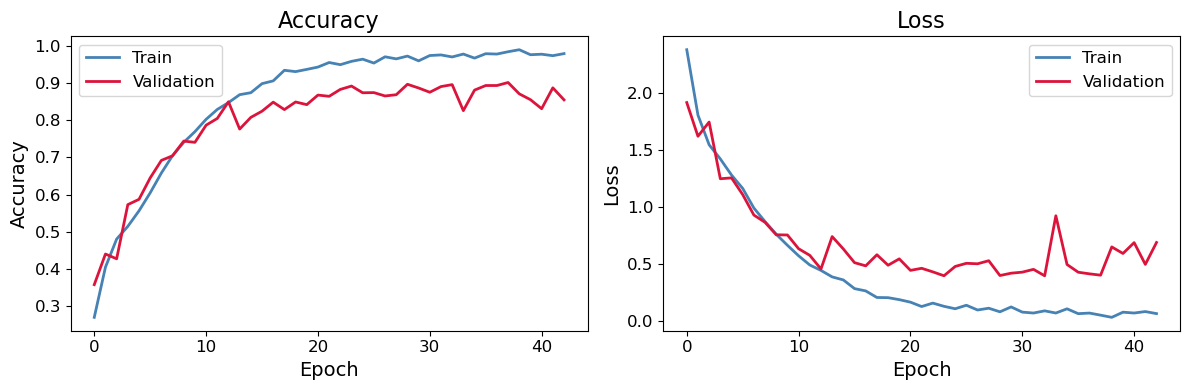

In [ ]:
plot_history_categorical(history=history_cnn_improved_act_bn, n_rows=1, n_cols=2,
						max_fontsize=16, figure_size=(12, 4), metrics=['accuracy', 'loss'])

### Transfer learning using EfficientNet
In addition to implementing a convolutional network of our own, we have tried to use an architecture based on <i>transfer learning</i>, but in this case using the <i>EfficientNetB0</i> network. This network, which is the simplest model of the different EfficientNets with about 5.3 million parameters, was proposed in 2019 as a solution to the problem of achieving high accuracies while keeping the computational cost of the models relatively low. [1] For this, they use <i>Compound Scaling</i> that combines depth, width and resolution to find the optimal coefficients for each combination. It also uses the method of searching for the optimal architecture within a space of possible networks and optimizes its accuracy and performance. The reference network for the search for the optimal architecture is based on the <i>MobileNetV2</i> network that uses a convolutional layer with a kernel size of 3x3 and different <i>MBConv</i> blocks. These blocks are formed by inverted residual blocks that use depth-separable convolutions [2] and an additional block called <i>Squeeze and Excitation (SE)</i> that combines the following layers <i>GlobalAveragePooling, Dense, ReLu, Dense, Sigmoid and a rescaling layer</i>. The function of the SE block is to selectively amplify the informative features of the images to the detriment of those that are not. [3] These two blocks (the inverted residuals and the <i>SE</i>) are placed between two convolutional layers with 1x1 filters to form the <i>MBConv</i> blocks that are the fundamental blocks of the architecture. [1] Finally, an activation function called <i>Swish</i> is also used, which is a non-monotonic function that has similar characteristics to ReLU in the range of positive values, but in the negative range the values ​​are not zero but draw a very smooth nonlinear function. [4]

The complicated architecture of the <i>EfficientNetB0</i> network has allowed to improve both the performance and the accuracy of convolutional network models such as ResNet50 with more than 25 million parameters and variations of <i>EfficientNetB0</i> have surpassed or equaled models with more than 100 million parameters. [1]

For all this, it has been decided to test its capacity on the current dataset.

<strong>References:</strong>
<br>
[1] Mingxing Tan, Quoc V. Le, <i>EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks</i>, arXiv:1905.11946 (2019).

[2] François Chollet, <i>Xception: Deep learning with depthwise separable convolutions</i>, arXiv:1610.02357 (2016).

[3] https://iq.opengenus.org/squeeze-and-excitation-network/

[4] https://en.wikipedia.org/wiki/Swish_function

In [66]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
# Define the preprocessing function to apply to each image in the dataset
def preprocess_data(inputs, targets):
    preprocessed_data = preprocess_input(inputs)
    return preprocessed_data, targets

# Use the map function to apply the preprocessing function to the datasets
train_efficientnet = train_data.map(preprocess_data)
validation_efficientnet = validation_data.map(preprocess_data)
test_efficientnet = test_data.map(preprocess_data)

In [67]:
check_dynamic_range(train_efficientnet, 1)

Channel 0: min = 0.0, max = 255.0
Channel 1: min = 0.0, max = 255.0
Channel 2: min = 0.0, max = 255.0


In [68]:
image_batch, labels_batch = next(iter(train_efficientnet))
image, label = image_batch[0], labels_batch[0]

In [69]:
label

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)>

Preprocessing the dataset returns images with a dynamic range between 0 and 255 and with the labels encoded with <i>one-hot encoding</i>.

#### Loading the pre-trained EfficientNet model
A function is defined that will load the EfficientNet model and allows you to select which weights to use, whether to include the final layers, and whether or not the layers are trained. Similar to exercise 5, the pre-trained model with ImageNet will be used. The last layers will also be removed and the weights will be frozen.

In [70]:
def load_pretrained_efficientnet(
    input_shape: tuple, weights: str, include_top: bool, trainable_layers: bool
) -> tf.keras.models.Model:
    """
    Loads the pretrained EfficientNetB0 model.
    
    The code is based on the implementations found in:
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
    - https://www.tensorflow.org/guide/keras/transfer_learning
    
    Parameters:
    -----------
    input_shape: tuple[int, int, int]
        Shape of the input images.
    weights: str
        Name of the pretrained dataset to use the weights from.
    include_top: bool
        Boolean to decide if the last layers of the neural network are removed or not.
    trainable_layers: bool
        Boolean to decide if the weights of the model layers are frozen or not.
    
    Returns:
    --------
    tf.keras.models.Model
        Pretrained EfficientNet model.
    """
    pretrained_efficientnet = EfficientNetB0(weights='imagenet', include_top=include_top, input_shape=input_shape)
    
    # Freeze all layers of the pretrained model
    for layer in pretrained_efficientnet.layers:
        layer.trainable = trainable_layers
    
    return pretrained_efficientnet

In [71]:
pretrained_efficientnet = load_pretrained_efficientnet(input_shape=(224, 224, 3), weights='imagenet', include_top=False, trainable_layers=False)

#### Definition of the network
In this case, it has been chosen to connect the EfficientNetB0 network using a <i>GlobalAveragePooling</i> layer which, as mentioned above, allows to reduce the dimensions of the layer by calculating the average value in all spatial positions. This allows to significantly reduce the number of parameters to be trained, making the models more efficient. In addition, this also has a regularizing effect, making the models less prone to overtraining. [1]

The fully connected layer of 1024 units has been used to connect the <i>GlobalAveragePooling2D</i>. The number of units has been chosen taking exercise 3 as an example and following the same arguments as the networks themselves. Thus, the greater the number of neurons, the better the features learned by the convolutional layers can be recognized in order to make predictions. However, if the number of units is too large, overfitting will also be introduced. [2-5] In this case, after several tests, a <i>Dropout</i> layer has not been introduced. [2] Finally, the last layer of 21 neurons aims to predict each of the categories with a probability defined by the <i>softmax</i> activation function. [2]

<strong>References:</strong>
<br>
[1] Min Lin, Qiang Chen, Shuicheng Yan, <i>Network in Network</i>, arXiv:1312.4400 (2014).

[2] Jordi Casas Roma and Anna Bosch Rue, <i>Fundamentos de las redes neuronales convolucionales</i>, UOC (2023).

[3] Jordi Casas Roma, <i>Las redes neuronales artificiales</i>, UOC (2023).

[4] Jordi Casas Roma, <i>Architecture and applications of convolutional neural networks</i>, UOC (2023).

[5] Jordi Torres, Python Deep Learning. Practical Introduction with Keras and TensorFlow 2</i>, Marcombo (2020).

In [ ]:
def efficientnet_model(pretrained_model: tf.keras.models.Model, input_shape: tuple, training: bool) -> tf.keras.models.Model:
    """
    Create a EfficientNet models by adding the last 3 layers according to the requirements of the exercise.
    
    The code is based on the implementations found in:
    - https://github.com/jcasasr/Libro-Deep-Learning
    - Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
    - Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
    - https://keras.io/guides/transfer_learning/
    - https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning
    
    Parameters:
    -----------
    pretrained_model: tf.keras.models.Model
        Instance with the pretrained EfficientNet model.
    input_shape: tuple[int, int, int]
        Input dimensions.
    training: bool
        Sets the model in inference mode to prevent updating the weights on BatchNormalization layers.
    
    Returns:
    --------
    tf.keras.models.Model
        Modified EfficientNet model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Sets the pretrained_model in inference mode
    base_model = pretrained_model(inputs, training=training)
    
    # Add the fully connected layers required to the pretrained EfficientNet model
    x = GlobalAveragePooling2D()(base_model)
    x = Dense(1024, activation='relu')(x)
    output = Dense(21, activation='softmax')(x)
    return Model(inputs, outputs=output)

In [73]:
modified_efficientnet = efficientnet_model(pretrained_efficientnet, input_shape=(224, 224, 3), training=False)

In [74]:
modified_efficientnet.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_9 (Dense)             (None, 21)                21525     
                                                                 
Total params: 5,382,840
Trainable params: 1,333,269
Non-trainable params: 4,049,571
_________________________________________

#### EfficientNet Network Compilation

In [ ]:
compiled_efficientnet = compile_model(model=modified_efficientnet, learning_rate=0.0001,
							optimizer=tf.keras.optimizers.Adam,
							loss=tf.keras.losses.CategoricalCrossentropy,
							metrics=['accuracy'])

#### EfficientNet network training

In [76]:
# Register the training time
start_time = time.time()

# Train the model
history_efficientnet = train_nn_model(train_efficientnet, validation_efficientnet, compiled_efficientnet, 
	epochs = 100, batch_size = 32, patience = 10, checkpoint_filepath = 'best_weights_efficientnet.h5')

# Finish time register
end_time = time.time() - start_time
print(f"The total training time is {end_time} seconds")

Epoch 1/100
230/230 [==============================] - 36s 127ms/step - loss: 0.9934 - accuracy: 0.8052 - val_loss: 0.3745 - val_accuracy: 0.9181
Epoch 2/100
230/230 [==============================] - 28s 117ms/step - loss: 0.2574 - accuracy: 0.9437 - val_loss: 0.2281 - val_accuracy: 0.9462
Epoch 3/100
230/230 [==============================] - 27s 117ms/step - loss: 0.1558 - accuracy: 0.9660 - val_loss: 0.1741 - val_accuracy: 0.9562
Epoch 4/100
230/230 [==============================] - 28s 118ms/step - loss: 0.1069 - accuracy: 0.9801 - val_loss: 0.1432 - val_accuracy: 0.9624
Epoch 5/100
230/230 [==============================] - 27s 114ms/step - loss: 0.0782 - accuracy: 0.9886 - val_loss: 0.1252 - val_accuracy: 0.9657
Epoch 6/100
230/230 [==============================] - 27s 116ms/step - loss: 0.0591 - accuracy: 0.9932 - val_loss: 0.1110 - val_accuracy: 0.9681
Epoch 7/100
230/230 [==============================] - 27s 116ms/step - loss: 0.0458 - accuracy: 0.9955 - val_loss: 0.0985 -

In [ ]:
test_loss, test_acc = compiled_efficientnet.evaluate(test_efficientnet)

33/33 [==============================] - 5s 124ms/step - loss: 0.0617 - accuracy: 0.9800


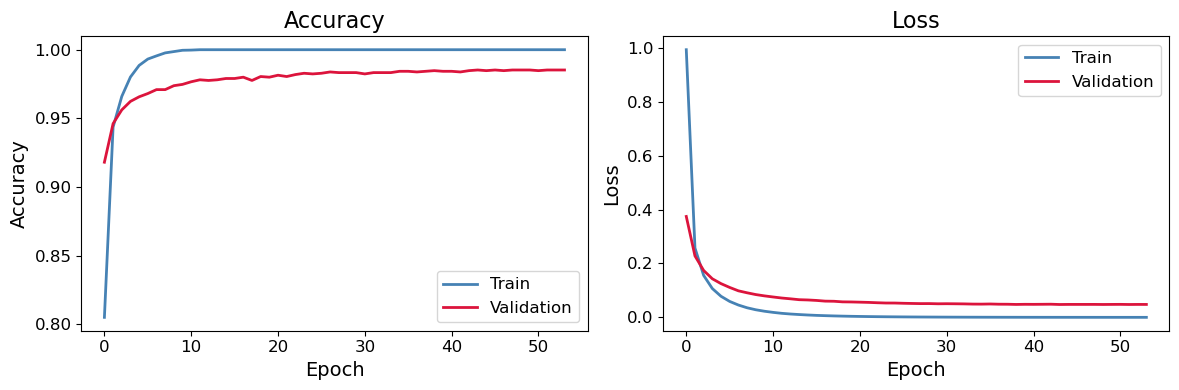

In [78]:
# Plot del training loss i l'accuracy
plot_history_categorical(history=history_efficientnet, n_rows=1, n_cols=2,
						max_fontsize=16, figure_size=(12, 4), metrics=['accuracy', 'loss'])

### Refinement of the EfficientNet
As in exercise 5, the network was refined with part of the current dataset to see if the results could be improved. Thus, the models were retrained by thawing the layers for 10 epochs and with a very small learning rate of 0.00001.

#### Definition of EfficientNet to be refined

In [ ]:
pretrained_efficientnet_finetuning = load_pretrained_efficientnet(input_shape=(224, 224, 3), weights='imagenet', include_top=False, trainable_layers=True)

In [103]:
modified_efficientnet_finetuning = efficientnet_model(pretrained_efficientnet_finetuning, input_shape=(224, 224, 3), training=False)
modified_efficientnet_finetuning.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_17 (Dense)            (None, 21)                21525     
                                                                 
Total params: 5,382,840
Trainable params: 5,340,817
Non-trainable params: 42,023
____________________________________________

#### Compiling the EfficientNet to be refined and loading the weights of the original network

In [ ]:
compiled_efficientnet_finetuning = compile_model(model=modified_efficientnet, learning_rate=0.00001,
							optimizer=tf.keras.optimizers.Adam,
							loss=tf.keras.losses.CategoricalCrossentropy,
							metrics=['accuracy'])

In [105]:
# Load the weights from the .h5 file
compiled_efficientnet_finetuning.load_weights('/kaggle/working/best_weights_efficientnet.h5')

#### EfficientNet training to be refined

In [106]:
# Register the training time
start_time = time.time()

# Train the model
history_efficientnet_finetuning = train_nn_model(train_efficientnet, validation_efficientnet, compiled_efficientnet_finetuning, 
	epochs = 10, batch_size = 32, patience = 10, checkpoint_filepath = 'best_weights_efficientnet_finetuning.h5')

# Finish time register
end_time = time.time() - start_time
print(f"The total training time is {end_time} seconds")

Epoch 1/10
230/230 [==============================] - 35s 124ms/step - loss: 1.4242e-04 - accuracy: 1.0000 - val_loss: 0.0473 - val_accuracy: 0.9857
Epoch 2/10
230/230 [==============================] - 27s 116ms/step - loss: 1.3386e-04 - accuracy: 1.0000 - val_loss: 0.0476 - val_accuracy: 0.9857
Epoch 3/10
230/230 [==============================] - 27s 117ms/step - loss: 1.2621e-04 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9857
Epoch 4/10
230/230 [==============================] - 28s 118ms/step - loss: 1.1904e-04 - accuracy: 1.0000 - val_loss: 0.0472 - val_accuracy: 0.9857
Epoch 5/10
230/230 [==============================] - 27s 115ms/step - loss: 1.1197e-04 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9857
Epoch 6/10
230/230 [==============================] - 28s 117ms/step - loss: 1.0552e-04 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9857
Epoch 7/10
230/230 [==============================] - 27s 116ms/step - loss: 9.9672e-05 - accuracy: 1.0000

#### EfficientNet evaluation to be refined

In [ ]:
test_loss, test_acc = compiled_efficientnet_finetuning.evaluate(test_efficientnet)

33/33 [==============================] - 3s 79ms/step - loss: 0.0608 - accuracy: 0.9790


#### Representation of the results for the EfficientNet to be refined

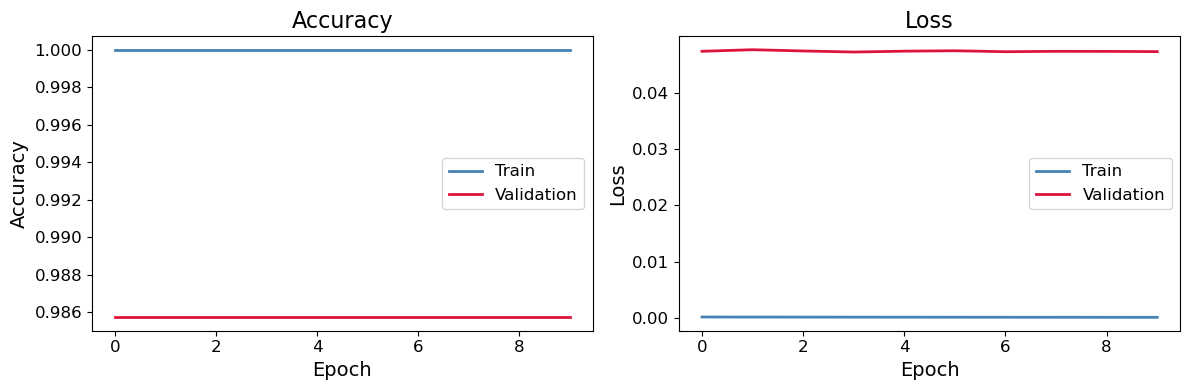

In [ ]:
plot_history_categorical(history=history_efficientnet_finetuning, n_rows=1, n_cols=2,
						max_fontsize=16, figure_size=(12, 4), metrics=['accuracy', 'loss'])

<strong>Comments on own networks:</strong>
<br>

According to the output of <code>model_cnn_act_bn.summary()</code> and <code>model_cnn_bn_act.summary()</code> the total number of parameters is 2,123,637, while only 2,121,621 will be trained, the remaining parameters (2016) correspond to the <i>Batch Normalization</i> layers.

The total time it took to train both models was between 1180-1575 seconds (~20-27 minutes), a little faster than the CNN network in exercise 3. It can be seen how the <i>accuracy</i> of training and validation increases progressively, while the <i>loss</i> decreases. Training has been stopped at <i>epoch</i> 56 and 43 for the <i>model_cnn_bn_act</i> and <i>model_cnn_act_bn</i> models, respectively, due to the implementation of <i>early stopping</i> which allows stopping training when there is no improvement in the validation <i>accuracy</i>, but rather that it starts to get worse, as explained on page 46 of [1].

The best values ​​of the <i>accuracies</i> are 0.9969 and 0.9200 for <i>model_cnn_bn_act</i> (training and validation sets) and, 0.9842 and 0.9014 for <i>model_cnn_act_bn</i> (training and validation sets), respectively. Regarding the <i>loss</i>, they are 0.0121 and 0.3340 for <i>model_cnn_bn_act</i> (training and validation sets) and 0.0524 and 0.4024 for <i>model_cnn_act_bn</i> (training and validation sets), respectively. These results are slightly better than those obtained with the small CNN network, but the same as the VGG-16 network. In addition, it is also observed that both the accuracy and the loss of <i>model_cnn_bn_act</i> have quite a few oscillations compared to the graphs of <i>model_cnn_act_bn</i> which is much more stable. This would seem to indicate that using <i>Batch Normalization</i> after the activation layer seems to work better.

The evaluation of the models with the test set returns accuracies of 0.9114 (<i>model_cnn_bn_act</i>) and 0.8943 (<i>model_cnn_act_bn</i>). On the other hand, the losses are 0.3451 (<i>model_cnn_bn_act</i>) and 0.4423 (<i>model_cnn_act_bn</i>). The accuracy results are slightly better than those obtained with the simple CNN network (<i>accuracy</i> of 0.8867), while the <i>loss</i> was 0.3692).

<strong>Comments transfer learning with EfficientNetB0:</strong>
<br>
According to the output of <code>modified_efficientnet.summary()</code> the total parameters are 5,382,840, while only 1,333,269 will be trained, which correspond to the parameters of the layers that have been added to the pre-trained model. Thus, the remaining 4,049,571 parameters that correspond to the pre-trained model are frozen as intended.

The total time it took to train the model was about 1560 seconds (~26 minutes), a little faster than the CNN network of exercise 3 and similar to the results of the CNN network itself. It can be seen how the <i>accuracy</i> of training and validation increases rapidly, while the <i>loss</i> decreases. The training has stopped at <i>epoch</i> 54 due to <i>early stopping</i>. Although the training times are similar to the previous ones, it can be seen that the accuracy obtained is much better with values ​​of 1.0 and 0.9852 for the training and validation sets, respectively, while the <i>loss</i> are 8.42e-5 and 0.0473, respectively. These results are better than those obtained with the rest of the many as mentioned. In fact, at the end of epoch 1 the accuracy was already more than 0.9. This is due to the complexity of the <i>EfficientNetB0</i> network and the implementations mentioned at the beginning of the section that allow learning the different characteristics of the images very well and the pre-training with the data from the <i>ImageNet</i> dataset.

The evaluation of the model with the test set returns an accuracy of 0.9800 and a loss of 0.0617 which are very similar to those of the validation set. In addition, the great similarity between the accuracies shows that there is no overtraining and that the model is able to generalize very well and predict the image categories perfectly.

In this case, the effect of the refinement is not very noticeable since only a slight improvement in accuracy has been achieved in the validation set from 0.9852 to 0.9857, while the evaluation of the results in the test set is similar (0.979 for accuracy and 0.0608 for loss).

<strong>References:</strong>
<br>
[1] Jordi Torres, <i>Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2</i>, Marcombo (2020).

[2] Jordi Casas Roma i Anna Bosch Rue, <i>Fundamentos de las redes neuronales convolucionales</i>, UOC (2023).    

[3] Jordi Casas Roma, <i>Arquitectura y aplicaciones de las redes neuronales convolucionales</i>, UOC (2023).

[4] https://www.tensorflow.org/guide/keras/transfer_learning
    
[6] Mingxing Tan, Quoc V. Le, <i>EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks</i>, arXiv:1905.11946 (2019).
</div>